# EEG Seizure Detection Pipeline

This notebook implements the seizure detection pipeline based on the flowchart design.

## Pipeline Overview
1. EEG Signal Input
2. Preprocessing & Artifact Removal
3. Channel Localization
4. Hemisphere Determination
5. Signal Analysis
6. Feature Extraction (Frequency, Time, Amplitude & Power)
7. Compare to Seizure Prototypes
8. Pattern Matching & Similarity Scoring
9. Seizure Detection & Classification
10. Output Results

## Setup and Imports

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.stats import kurtosis, skew
import pandas as pd
from datetime import datetime
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Import our existing EDFConverter
from edf_converter import EDFConverter

# Set matplotlib style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## Configuration - Easy Algorithm Selection

Modify these dictionaries to switch between different algorithms

In [27]:
# Algorithm Configuration
CONFIG = {
    # Preprocessing algorithms
    'preprocessing': {
        'filter_type': 'butterworth',  # Options: 'butterworth', 'fir', 'iir'
        'lowpass_freq': 40.0,  # Hz
        'highpass_freq': 0.5,  # Hz
        'notch_freq': 60.0,  # Hz (50 for Europe, 60 for US)
        'artifact_removal': 'ica',  # Options: 'ica', 'regression', 'threshold'
    },
    
    # Feature extraction methods (for legacy compatibility)
    'feature_extraction': {
        'frequency_method': 'welch',  # Options: 'welch', 'fft', 'multitaper'
        'time_features': ['mean', 'std', 'kurtosis', 'skewness', 'line_length'],
        'frequency_bands': {
            'delta': (0.5, 4),
            'theta': (4, 8),
            'alpha': (8, 13),
            'beta': (13, 30),
            'gamma': (30, 40)
        }
    },

    # Sliding window analysis
    'pattern_matching': {
        'algorithm': 'real_signal_analysis',  # NEW: Uses actual EEG signal analysis
        'window_size': 5.0,  # seconds
        'overlap': 0.5  # 50% overlap
    },

    # Detection thresholds (for the new real signal analysis detector)
    'thresholds': {
        'high_confidence': 0.70,  # High confidence detection
        'detection': 0.50,  # Detection threshold (combined score)
        'low_confidence': 0.35,  # Low confidence threshold
    },

    # Real Signal Analysis Detector Parameters
    # These can be adjusted to tune sensitivity/specificity
    'detector_params': {
        # Spike detection
        'spike_threshold_std': 4.0,  # Standard deviations for spike detection
        'spike_rate_threshold': 3.0,  # Spikes per second to flag as seizure

        # Power analysis thresholds
        'ictal_delta_increase': 2.0,  # Delta power must increase by this factor
        'ictal_theta_increase': 2.5,  # Theta power increase factor
        'ictal_beta_gamma_increase': 3.0,  # High frequency increase factor

        # Line length
        'line_length_threshold': 2.5,  # Times baseline to flag

        # Overall
        'detection_threshold': 0.5,  # Combined score threshold
    }
}

print("Configuration loaded:")
print("=" * 70)
for key, value in CONFIG.items():
    print(f"\n{key}:")
    if isinstance(value, dict):
        for k, v in value.items():
            print(f"  {k}: {v}")
    else:
        print(f"  {value}")

print("\n" + "=" * 70)
print("NEW: Real Signal Analysis Seizure Detection")
print("=" * 70)
print("""
The detector now uses actual EEG signal analysis techniques:

1. SPIKE DETECTION
   - Morphological analysis for epileptiform spikes
   - Threshold-based detection with duration filtering
   - Spike rate calculation

2. RHYTHMIC ACTIVITY
   - 2.5-4 Hz detection for absence seizures (3 Hz spike-wave)
   - Power spectral analysis in rhythmic bands

3. POWER SPECTRUM ANALYSIS
   - Delta/Theta increase detection
   - Beta/Gamma increase detection
   - Alpha suppression detection
   - All compared to baseline

4. LINE LENGTH
   - Signal complexity measure
   - Elevated during seizure activity

5. ENTROPY ANALYSIS
   - Detects changes in signal regularity
   - Both increased and decreased entropy

6. AMPLITUDE ANALYSIS
   - RMS and peak-to-peak analysis
   - Compared to baseline

Each component contributes to a combined seizure probability score.
Threshold tuning is possible via CONFIG['detector_params'].
""")

Configuration loaded:

preprocessing:
  filter_type: butterworth
  lowpass_freq: 40.0
  highpass_freq: 0.5
  notch_freq: 60.0
  artifact_removal: ica

feature_extraction:
  frequency_method: welch
  time_features: ['mean', 'std', 'kurtosis', 'skewness', 'line_length']
  frequency_bands: {'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 13), 'beta': (13, 30), 'gamma': (30, 40)}

pattern_matching:
  algorithm: real_signal_analysis
  window_size: 5.0
  overlap: 0.5

thresholds:
  high_confidence: 0.7
  detection: 0.5
  low_confidence: 0.35

detector_params:
  spike_threshold_std: 4.0
  spike_rate_threshold: 3.0
  ictal_delta_increase: 2.0
  ictal_theta_increase: 2.5
  ictal_beta_gamma_increase: 3.0
  line_length_threshold: 2.5
  detection_threshold: 0.5

NEW: Real Signal Analysis Seizure Detection

The detector now uses actual EEG signal analysis techniques:

1. SPIKE DETECTION
   - Morphological analysis for epileptiform spikes
   - Threshold-based detection with duration filtering
   - 

## 1. EEG Signal Input

### Data Input Options:
- **Option A**: Load from EDF file using EDFConverter
- **Option B**: Load from preprocessed NumPy array
- **Option C**: Use placeholder data for testing

**TODO**: Replace with your actual data when available

In [28]:
import glob
from pathlib import Path

class EventAnnotations:
    """Load and parse seizure event annotations"""

    def __init__(self, events_file: str):
        """Load event annotations from file"""
        self.events_file = Path(events_file)
        self.events = self._load_events()

    def _load_events(self) -> pd.DataFrame:
        """Parse events file"""
        if not self.events_file.exists():
            print(f"Warning: Events file not found: {self.events_file}")
            return pd.DataFrame()

        df = pd.read_csv(self.events_file, sep='\t')
        # Filter for seizure events only (not impedance checks)
        seizure_events = df[df['eventType'].str.contains('sz_', na=False)]
        return seizure_events

    def get_seizure_windows(self) -> List[Dict]:
        """Get seizure time windows with annotations"""
        windows = []
        for _, event in self.events.iterrows():
            onset = event['onset']
            duration = event['duration']
            event_type = event['eventType']
            lateralization = event.get('lateralization', 'unknown')
            localization = event.get('localization', 'unknown')

            windows.append({
                'start_time': onset,
                'end_time': onset + duration,
                'duration': duration,
                'event_type': event_type,
                'lateralization': lateralization,
                'localization': localization
            })
        return windows

    def display_annotations(self):
        """Display all seizure annotations"""
        print(f"\nSeizure Annotations from {self.events_file.name}:")
        print("=" * 70)
        for i, event in enumerate(self.get_seizure_windows(), 1):
            print(f"\nSeizure {i}:")
            print(f"  Time: {event['start_time']:.1f}s - {event['end_time']:.1f}s")
            print(f"  Duration: {event['duration']:.1f}s")
            print(f"  Type: {event['event_type']}")
            print(f"  Lateralization: {event['lateralization']}")
            print(f"  Localization: {event['localization']}")


class EEGDataLoader:
    """Flexible data loader for EEG signals"""

    def __init__(self):
        self.data = None
        self.times = None
        self.channel_names = None
        self.sfreq = None
        self.info = None
        self.annotations = None
        self.filepath = None

    def load_from_edf(self, filepath: str, channels: Optional[List[str]] = None):
        """Load data from EDF file"""
        self.filepath = Path(filepath)
        converter = EDFConverter(str(filepath))
        self.data, self.times = converter.get_data(channels=channels)
        info = converter.get_info()
        self.channel_names = info['channel_names']
        self.sfreq = info['sampling_rate']
        self.info = info

        # Try to load corresponding events file
        # Handle naming convention: _eeg.edf -> _events.txt
        events_filename = self.filepath.name.replace('_eeg.edf', '_events.txt')
        events_file = self.filepath.parent / events_filename

        # Fallback: try appending _events.txt to stem
        if not events_file.exists():
            events_file = self.filepath.parent / f"{self.filepath.stem}_events.txt"

        if events_file.exists():
            self.annotations = EventAnnotations(str(events_file))
            print(f"Loaded EDF: {info['n_channels']} channels, {info['duration_seconds']:.2f}s duration")
            print(f"Loaded annotations: {len(self.annotations.events)} seizure events found")
            self.annotations.display_annotations()
        else:
            print(f"Loaded EDF: {info['n_channels']} channels, {info['duration_seconds']:.2f}s duration")
            print(f"No events file found at: {events_file}")

        return self

    def load_from_numpy(self, data: np.ndarray, sfreq: float,
                       channel_names: Optional[List[str]] = None):
        """Load data from NumPy array"""
        self.data = data
        self.sfreq = sfreq
        self.times = np.arange(data.shape[1]) / sfreq
        self.channel_names = channel_names or [f"Ch{i+1}" for i in range(data.shape[0])]
        print(f"Loaded NumPy array: {data.shape[0]} channels, {self.times[-1]:.2f}s duration")
        return self

    @staticmethod
    def list_available_edf_files(data_dir: str = 'data') -> List[str]:
        """List all available EDF files in the data directory"""
        data_path = Path(data_dir)
        if not data_path.exists():
            print(f"Data directory not found: {data_dir}")
            return []

        edf_files = list(data_path.glob("*.edf"))
        return [str(f) for f in sorted(edf_files)]

# ===== DATA LOADING =====

# List available EDF files
print("Available EDF files:")
print("=" * 70)
available_files = EEGDataLoader.list_available_edf_files('data')
for i, filepath in enumerate(available_files, 1):
    print(f"  {i}. {Path(filepath).name}")

if not available_files:
    raise FileNotFoundError("No EDF files found in data/ directory. Please add EDF files to proceed.")

# Initialize data loader and load the first EDF file
loader = EEGDataLoader()
print(f"\n{'=' * 70}")
print(f"Loading: {Path(available_files[0]).name}")
print("=" * 70)
loader.load_from_edf(available_files[0])

print(f"\n{'=' * 70}")
print(f"Data shape: {loader.data.shape}")
print(f"Sampling rate: {loader.sfreq} Hz")
print(f"Duration: {loader.times[-1]:.2f} seconds ({loader.times[-1]/3600:.2f} hours)")


Available EDF files:
  1. sub-013_ses-01_task-szMonitoring_run-01_eeg.edf
  2. sub-053_ses-01_task-szMonitoring_run-03_eeg.edf
  3. sub-053_ses-01_task-szMonitoring_run-04_eeg.edf

Loading: sub-013_ses-01_task-szMonitoring_run-01_eeg.edf
Loaded EDF: 2 channels, 69388.00s duration
Loaded annotations: 2 seizure events found

Seizure Annotations from sub-013_ses-01_task-szMonitoring_run-01_events.txt:

Seizure 1:
  Time: 13124.0s - 13145.0s
  Duration: 21.0s
  Type: sz_foc_ia_nm
  Lateralization: left
  Localization: temp

Seizure 2:
  Time: 43588.0s - 43609.0s
  Duration: 21.0s
  Type: sz_foc_ia_nm
  Lateralization: left
  Localization: temp

Data shape: (2, 17763328)
Sampling rate: 256.0 Hz
Duration: 69388.00 seconds (19.27 hours)


## 2. Preprocessing & Artifact Removal

Preprocessing...
  Bandpass filter: 0.5-40.0 Hz
  Notch filter: 60.0 Hz
  Using ICA artifact removal (placeholder)
✓ Preprocessing complete


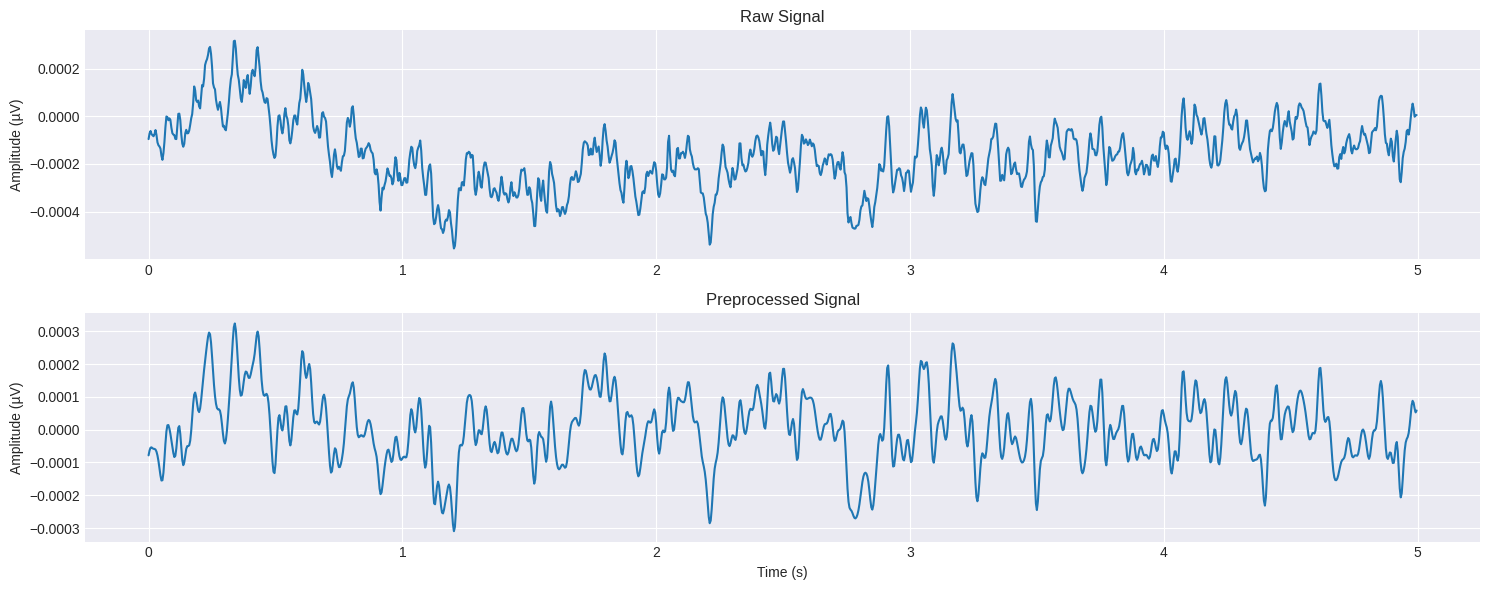

In [29]:
class Preprocessor:
    """Preprocessing and artifact removal"""

    def __init__(self, config: Dict):
        self.config = config

    def bandpass_filter(self, data: np.ndarray, sfreq: float) -> np.ndarray:
        """Apply bandpass filter"""
        low = self.config['highpass_freq']
        high = self.config['lowpass_freq']
        nyq = sfreq / 2

        if self.config['filter_type'] == 'butterworth':
            sos = signal.butter(4, [low/nyq, high/nyq], btype='band', output='sos')
            filtered = signal.sosfiltfilt(sos, data, axis=1)
        else:
            # Add other filter types here
            filtered = data

        return filtered

    def notch_filter(self, data: np.ndarray, sfreq: float) -> np.ndarray:
        """Remove powerline noise"""
        notch_freq = self.config['notch_freq']
        Q = 30  # Quality factor
        b, a = signal.iirnotch(notch_freq, Q, sfreq)
        filtered = signal.filtfilt(b, a, data, axis=1)
        return filtered

    def remove_artifacts(self, data: np.ndarray, sfreq: float) -> np.ndarray:
        """Remove artifacts - placeholder for different methods"""
        method = self.config['artifact_removal']

        if method == 'ica':
            # Placeholder for ICA-based artifact removal
            # TODO: Implement full ICA when needed
            print("  Using ICA artifact removal (placeholder)")
            return data

        elif method == 'threshold':
            # Simple threshold-based artifact rejection
            threshold = 5 * np.std(data)
            data_clean = data.copy()
            data_clean[np.abs(data) > threshold] = np.nan
            # Interpolate NaN values
            for ch in range(data_clean.shape[0]):
                mask = np.isnan(data_clean[ch])
                if mask.any():
                    data_clean[ch][mask] = np.interp(
                        np.where(mask)[0],
                        np.where(~mask)[0],
                        data_clean[ch][~mask]
                    )
            return data_clean

        else:
            print(f"  Artifact removal method '{method}' not implemented")
            return data

    def preprocess(self, data: np.ndarray, sfreq: float) -> np.ndarray:
        """Full preprocessing pipeline"""
        print("Preprocessing...")
        data_clean = data.copy()

        # Apply filters
        print(f"  Bandpass filter: {self.config['highpass_freq']}-{self.config['lowpass_freq']} Hz")
        data_clean = self.bandpass_filter(data_clean, sfreq)

        print(f"  Notch filter: {self.config['notch_freq']} Hz")
        data_clean = self.notch_filter(data_clean, sfreq)

        # Remove artifacts
        data_clean = self.remove_artifacts(data_clean, sfreq)

        print("✓ Preprocessing complete")
        return data_clean

# Apply preprocessing
preprocessor = Preprocessor(CONFIG['preprocessing'])
data_clean = preprocessor.preprocess(loader.data, loader.sfreq)

# Visualize before/after
fig, axes = plt.subplots(2, 1, figsize=(15, 6))
ch_idx = 0  # Show first channel
time_window = (0, 5)  # First 5 seconds
idx_start = int(time_window[0] * loader.sfreq)
idx_end = int(time_window[1] * loader.sfreq)

axes[0].plot(loader.times[idx_start:idx_end], loader.data[ch_idx, idx_start:idx_end])
axes[0].set_title('Raw Signal')
axes[0].set_ylabel('Amplitude (µV)')

axes[1].plot(loader.times[idx_start:idx_end], data_clean[ch_idx, idx_start:idx_end])
axes[1].set_title('Preprocessed Signal')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Amplitude (µV)')

plt.tight_layout()
plt.show()

## 3. Channel Localization & Hemisphere Determination

In [30]:
class ChannelLocalizer:
    """Determine hemisphere and localization of channels"""

    # Standard 10-20 system hemisphere mapping
    HEMISPHERE_MAP = {
        'left': ['F7', 'F3', 'T3', 'T7', 'C3', 'T5', 'P3', 'O1', 'Fp1', 'A1'],
        'right': ['F8', 'F4', 'T4', 'T8', 'C4', 'T6', 'P4', 'O2', 'Fp2', 'A2'],
        'midline': ['Fz', 'Cz', 'Pz', 'Oz']
    }

    def __init__(self, channel_names: List[str]):
        self.channel_names = channel_names
        self.localization = self._localize_channels()

    def _localize_channels(self) -> Dict[str, List[int]]:
        """Map channels to hemispheres"""
        localization = {'left': [], 'right': [], 'midline': [], 'unknown': []}

        for idx, ch_name in enumerate(self.channel_names):
            # Check against standard positions
            found = False
            for hemisphere, positions in self.HEMISPHERE_MAP.items():
                if any(pos in ch_name.upper() for pos in positions):
                    localization[hemisphere].append(idx)
                    found = True
                    break

            if not found:
                # Try to infer from naming conventions
                if any(x in ch_name for x in ['1', '3', '5', '7']) and 'L' not in ch_name:
                    localization['left'].append(idx)
                elif any(x in ch_name for x in ['2', '4', '6', '8']) and 'R' not in ch_name:
                    localization['right'].append(idx)
                else:
                    localization['unknown'].append(idx)

        return localization

    def determine_hemisphere(self, data: np.ndarray, window: Tuple[int, int]) -> str:
        """Determine which hemisphere(s) show activity in time window"""
        start_idx, end_idx = window

        # Calculate power in each hemisphere
        left_power = 0
        right_power = 0

        for idx in self.localization['left']:
            left_power += np.sum(data[idx, start_idx:end_idx] ** 2)

        for idx in self.localization['right']:
            right_power += np.sum(data[idx, start_idx:end_idx] ** 2)

        # Normalize by number of channels
        if len(self.localization['left']) > 0:
            left_power /= len(self.localization['left'])
        if len(self.localization['right']) > 0:
            right_power /= len(self.localization['right'])

        # Determine dominance
        ratio = left_power / (right_power + 1e-10)

        if 0.7 < ratio < 1.3:  # Both hemispheres involved
            return 'bilateral'
        elif ratio > 1.3:
            return 'left'
        else:
            return 'right'

    def get_hemisphere_channels(self, hemisphere: str) -> Tuple[List[int], List[str]]:
        """Get channel indices and names for a hemisphere"""
        if hemisphere == 'bilateral':
            indices = self.localization['left'] + self.localization['right']
        else:
            indices = self.localization[hemisphere]

        names = [self.channel_names[i] for i in indices]
        return indices, names

# Initialize channel localizer
localizer = ChannelLocalizer(loader.channel_names)

print("Channel Localization:")
for hemisphere, indices in localizer.localization.items():
    if indices:
        channels = [loader.channel_names[i] for i in indices]
        print(f"  {hemisphere.capitalize()}: {len(indices)} channels - {channels[:5]}...")

# Test hemisphere determination on a window
test_window = (int(15 * loader.sfreq), int(16 * loader.sfreq))  # 15-16 seconds
hemisphere = localizer.determine_hemisphere(data_clean, test_window)
print(f"\nTest window (15-16s) hemisphere: {hemisphere}")

Channel Localization:
  Unknown: 2 channels - ['BTEleft SD', 'CROSStop SD']...

Test window (15-16s) hemisphere: right


## 4. Signal Analysis Module - Feature Extraction

Extract features from three domains:
- **Frequency Domain**: Power spectral density, band powers
- **Time Domain**: Statistical features, morphology
- **Amplitude & Power**: Peak detection, energy

In [31]:
class FeatureExtractor:
    """Extract features from EEG signals"""

    def __init__(self, config: Dict, sfreq: float):
        self.config = config
        self.sfreq = sfreq
        self.bands = config['frequency_bands']

    def extract_frequency_features(self, data: np.ndarray) -> Dict[str, np.ndarray]:
        """Extract frequency domain features"""
        features = {}
        method = self.config['frequency_method']

        for ch_idx in range(data.shape[0]):
            if method == 'welch':
                freqs, psd = signal.welch(data[ch_idx], fs=self.sfreq, nperseg=min(256, len(data[ch_idx])//2))
            elif method == 'fft':
                fft_vals = fft(data[ch_idx])
                freqs = fftfreq(len(data[ch_idx]), 1/self.sfreq)
                psd = np.abs(fft_vals) ** 2
            else:
                # Default to welch
                freqs, psd = signal.welch(data[ch_idx], fs=self.sfreq)

            # Calculate band powers
            for band_name, (low, high) in self.bands.items():
                band_mask = (freqs >= low) & (freqs <= high)
                band_power = np.trapz(psd[band_mask], freqs[band_mask])

                if ch_idx == 0:
                    features[f'{band_name}_power'] = []
                features[f'{band_name}_power'].append(band_power)

        # Convert to arrays
        for key in features:
            features[key] = np.array(features[key])

        # Add spectral edge frequency
        features['spectral_edge'] = np.array([freqs[np.where(np.cumsum(psd)/np.sum(psd) > 0.95)[0][0]]
                                              for ch_idx in range(data.shape[0])])

        return features

    def extract_time_features(self, data: np.ndarray) -> Dict[str, np.ndarray]:
        """Extract time domain features"""
        features = {}
        requested = self.config['time_features']

        if 'mean' in requested:
            features['mean'] = np.mean(data, axis=1)

        if 'std' in requested:
            features['std'] = np.std(data, axis=1)

        if 'kurtosis' in requested:
            features['kurtosis'] = kurtosis(data, axis=1)

        if 'skewness' in requested:
            features['skewness'] = skew(data, axis=1)

        if 'line_length' in requested:
            # Line length: sum of absolute differences
            features['line_length'] = np.sum(np.abs(np.diff(data, axis=1)), axis=1)

        if 'zero_crossings' in requested:
            features['zero_crossings'] = np.sum(np.diff(np.sign(data), axis=1) != 0, axis=1)

        return features

    def extract_amplitude_power_features(self, data: np.ndarray) -> Dict[str, np.ndarray]:
        """Extract amplitude and power features"""
        features = {}

        # Peak-to-peak amplitude
        features['peak_to_peak'] = np.ptp(data, axis=1)

        # RMS (root mean square) - measure of signal power
        features['rms'] = np.sqrt(np.mean(data ** 2, axis=1))

        # Energy
        features['energy'] = np.sum(data ** 2, axis=1)

        # Peak amplitude
        features['max_amplitude'] = np.max(np.abs(data), axis=1)

        return features

    def extract_all_features(self, data: np.ndarray) -> pd.DataFrame:
        """Extract all features and return as DataFrame"""
        all_features = {}

        # Frequency domain
        freq_features = self.extract_frequency_features(data)
        all_features.update(freq_features)

        # Time domain
        time_features = self.extract_time_features(data)
        all_features.update(time_features)

        # Amplitude & Power
        amp_features = self.extract_amplitude_power_features(data)
        all_features.update(amp_features)

        # Create DataFrame
        df = pd.DataFrame(all_features)
        return df

# Extract features from a window
extractor = FeatureExtractor(CONFIG['feature_extraction'], loader.sfreq)

# Extract features from 15-20 second window (where we added synthetic seizure)
window_start = int(15 * loader.sfreq)
window_end = int(20 * loader.sfreq)
window_data = data_clean[:, window_start:window_end]

features_df = extractor.extract_all_features(window_data)
print("\nExtracted Features (15-20s window):")
print(features_df.head())
print(f"\nTotal features extracted: {len(features_df.columns)}")
print(f"Feature names: {list(features_df.columns)}")


Extracted Features (15-20s window):
    delta_power   theta_power   alpha_power    beta_power   gamma_power  \
0  3.841546e-09  1.889529e-09  1.369926e-09  1.733649e-09  2.290892e-10   
1  3.236541e-08  1.041446e-08  3.838810e-09  9.205976e-09  2.460638e-09   

   spectral_edge      mean       std  kurtosis  skewness  line_length  \
0           25.0 -0.000007  0.000107 -0.168721 -0.079207     0.026961   
1           25.0  0.000006  0.000271  0.176880 -0.211350     0.042386   

   peak_to_peak       rms    energy  max_amplitude  
0      0.000607  0.000107  0.000015       0.000304  
1      0.001924  0.000271  0.000094       0.001019  

Total features extracted: 15
Feature names: ['delta_power', 'theta_power', 'alpha_power', 'beta_power', 'gamma_power', 'spectral_edge', 'mean', 'std', 'kurtosis', 'skewness', 'line_length', 'peak_to_peak', 'rms', 'energy', 'max_amplitude']


## 5. Seizure Prototype Database

Define characteristic features for different seizure types

In [32]:
class SeizureDetector:
    """
    Real signal analysis-based seizure detector.

    Uses multiple detection methods:
    1. Statistical deviation from baseline
    2. Spike detection (morphological analysis)
    3. Rhythmic activity detection
    4. Power ratio analysis
    5. Line length analysis
    6. Entropy-based detection

    Each method contributes to an overall seizure probability score.
    """

    def __init__(self, sfreq: float, config: Dict = None):
        self.sfreq = sfreq
        self.config = config or {}

        # Detection parameters (can be tuned)
        self.params = {
            # Baseline estimation
            'baseline_percentile': 50,  # Use median for robust baseline
            'baseline_window_minutes': 5,  # Minutes of data for baseline

            # Spike detection
            'spike_threshold_std': 4.0,  # Standard deviations above mean
            'spike_min_duration_ms': 20,  # Minimum spike duration
            'spike_max_duration_ms': 200,  # Maximum spike duration
            'spike_rate_threshold': 3.0,  # Spikes per second to flag

            # Rhythmic activity (for absence seizures)
            'rhythmic_freq_range': (2.5, 4.0),  # 3 Hz spike-wave
            'rhythmic_power_threshold': 3.0,  # Times baseline

            # Power analysis
            'ictal_delta_increase': 2.0,  # Delta power increase factor
            'ictal_theta_increase': 2.5,  # Theta power increase factor
            'ictal_beta_gamma_increase': 3.0,  # High freq increase
            'alpha_suppression': 0.5,  # Alpha reduction during seizure

            # Line length
            'line_length_threshold': 2.5,  # Times baseline

            # Entropy
            'entropy_change_threshold': 0.3,  # Significant entropy change

            # Overall detection
            'detection_threshold': 0.5,  # Combined score threshold
            'high_confidence_threshold': 0.7,
            'min_seizure_duration_sec': 3.0,  # Minimum duration to call seizure
        }

        # Baseline statistics (computed from initial data)
        self.baseline = None
        self.baseline_computed = False

    def compute_baseline(self, data: np.ndarray, use_first_minutes: float = 5.0):
        """
        Compute baseline statistics from a segment of the recording.
        Should ideally be computed from known non-seizure periods.

        Parameters:
        -----------
        data : np.ndarray
            Full recording data (n_channels, n_samples)
        use_first_minutes : float
            Minutes of data to use for baseline (assumes start is seizure-free)
        """
        # Use specified duration or 10% of recording, whichever is smaller
        baseline_samples = min(
            int(use_first_minutes * 60 * self.sfreq),
            data.shape[1] // 10
        )

        # Use middle portion if recording is very short
        if baseline_samples < int(60 * self.sfreq):
            baseline_samples = min(int(60 * self.sfreq), data.shape[1] // 2)

        baseline_data = data[:, :baseline_samples]

        print(f"Computing baseline from first {baseline_samples/self.sfreq:.1f} seconds...")

        # Compute baseline statistics
        self.baseline = {
            'mean': np.mean(baseline_data, axis=1),
            'std': np.std(baseline_data, axis=1),
            'median': np.median(baseline_data, axis=1),
            'mad': np.median(np.abs(baseline_data - np.median(baseline_data, axis=1, keepdims=True)), axis=1),
            'rms': np.sqrt(np.mean(baseline_data ** 2, axis=1)),
            'line_length': np.sum(np.abs(np.diff(baseline_data, axis=1)), axis=1) / baseline_samples,
        }

        # Compute baseline power spectrum
        baseline_powers = self._compute_band_powers(baseline_data)
        self.baseline['powers'] = baseline_powers

        # Compute baseline entropy
        self.baseline['entropy'] = self._compute_entropy(baseline_data)

        self.baseline_computed = True
        print(f"  Baseline RMS: {np.mean(self.baseline['rms']):.6f}")
        print(f"  Baseline STD: {np.mean(self.baseline['std']):.6f}")
        print("  Baseline computed successfully")

    def _compute_band_powers(self, data: np.ndarray) -> Dict[str, np.ndarray]:
        """Compute power in standard EEG frequency bands"""
        bands = {
            'delta': (0.5, 4),
            'theta': (4, 8),
            'alpha': (8, 13),
            'beta': (13, 30),
            'gamma': (30, 45),
            'high_gamma': (45, 80),
        }

        powers = {}
        for ch_idx in range(data.shape[0]):
            freqs, psd = signal.welch(data[ch_idx], fs=self.sfreq,
                                      nperseg=min(int(self.sfreq * 2), len(data[ch_idx])//2))

            for band_name, (low, high) in bands.items():
                band_mask = (freqs >= low) & (freqs <= high)
                if band_mask.any():
                    band_power = np.trapz(psd[band_mask], freqs[band_mask])
                else:
                    band_power = 0

                if band_name not in powers:
                    powers[band_name] = []
                powers[band_name].append(band_power)

        return {k: np.array(v) for k, v in powers.items()}

    def _compute_entropy(self, data: np.ndarray, bins: int = 50) -> np.ndarray:
        """Compute sample entropy approximation for each channel"""
        entropies = []
        for ch_idx in range(data.shape[0]):
            # Normalize data
            ch_data = data[ch_idx]
            ch_normalized = (ch_data - np.mean(ch_data)) / (np.std(ch_data) + 1e-10)

            # Compute histogram-based entropy
            hist, _ = np.histogram(ch_normalized, bins=bins, density=True)
            hist = hist[hist > 0]  # Remove zero bins
            entropy = -np.sum(hist * np.log2(hist + 1e-10)) / np.log2(bins)
            entropies.append(entropy)

        return np.array(entropies)

    def detect_spikes(self, data: np.ndarray) -> Dict:
        """
        Detect epileptiform spikes using morphological analysis.

        Returns spike count, rate, and locations.
        """
        if not self.baseline_computed:
            # Use data statistics if no baseline
            threshold = np.std(data, axis=1) * self.params['spike_threshold_std']
        else:
            # Use baseline + threshold
            threshold = self.baseline['std'] * self.params['spike_threshold_std']

        min_samples = int(self.params['spike_min_duration_ms'] * self.sfreq / 1000)
        max_samples = int(self.params['spike_max_duration_ms'] * self.sfreq / 1000)

        spike_counts = []
        spike_indices = []

        for ch_idx in range(data.shape[0]):
            ch_data = np.abs(data[ch_idx])

            # Find peaks above threshold
            above_thresh = ch_data > threshold[ch_idx]

            # Find spike candidates (contiguous regions above threshold)
            diff = np.diff(above_thresh.astype(int))
            starts = np.where(diff == 1)[0]
            ends = np.where(diff == -1)[0]

            # Handle edge cases
            if len(starts) == 0 or len(ends) == 0:
                spike_counts.append(0)
                spike_indices.append([])
                continue

            if starts[0] > ends[0]:
                ends = ends[1:]
            if len(starts) > len(ends):
                starts = starts[:len(ends)]

            # Filter by duration
            spikes = []
            for start, end in zip(starts, ends):
                duration = end - start
                if min_samples <= duration <= max_samples:
                    # Check for sharp morphology (rapid rise/fall)
                    peak_idx = start + np.argmax(ch_data[start:end])
                    spikes.append(peak_idx)

            spike_counts.append(len(spikes))
            spike_indices.append(spikes)

        duration_sec = data.shape[1] / self.sfreq
        spike_rates = np.array(spike_counts) / duration_sec

        return {
            'spike_counts': np.array(spike_counts),
            'spike_rates': spike_rates,
            'spike_indices': spike_indices,
            'mean_spike_rate': np.mean(spike_rates),
            'max_spike_rate': np.max(spike_rates),
            'spike_detected': np.max(spike_rates) > self.params['spike_rate_threshold']
        }

    def detect_rhythmic_activity(self, data: np.ndarray) -> Dict:
        """
        Detect rhythmic activity characteristic of seizures.
        Focuses on 3 Hz spike-wave (absence) and other ictal rhythms.
        """
        low, high = self.params['rhythmic_freq_range']

        rhythmic_powers = []
        total_powers = []

        for ch_idx in range(data.shape[0]):
            freqs, psd = signal.welch(data[ch_idx], fs=self.sfreq,
                                      nperseg=min(int(self.sfreq * 2), len(data[ch_idx])//2))

            # Power in rhythmic range (e.g., 2.5-4 Hz for absence)
            rhythmic_mask = (freqs >= low) & (freqs <= high)
            rhythmic_power = np.trapz(psd[rhythmic_mask], freqs[rhythmic_mask]) if rhythmic_mask.any() else 0

            # Total power for normalization
            total_power = np.trapz(psd, freqs)

            rhythmic_powers.append(rhythmic_power)
            total_powers.append(total_power)

        rhythmic_powers = np.array(rhythmic_powers)
        total_powers = np.array(total_powers)

        # Compare to baseline if available
        if self.baseline_computed and 'powers' in self.baseline:
            baseline_theta = self.baseline['powers'].get('theta', rhythmic_powers)
            rhythmic_ratio = rhythmic_powers / (baseline_theta + 1e-10)
        else:
            # Use relative power
            rhythmic_ratio = rhythmic_powers / (total_powers + 1e-10) * 10  # Scale factor

        return {
            'rhythmic_power': rhythmic_powers,
            'rhythmic_ratio': rhythmic_ratio,
            'mean_rhythmic_ratio': np.mean(rhythmic_ratio),
            'rhythmic_detected': np.mean(rhythmic_ratio) > self.params['rhythmic_power_threshold']
        }

    def analyze_power_changes(self, data: np.ndarray) -> Dict:
        """
        Analyze power spectrum changes indicative of seizures.

        Ictal patterns typically show:
        - Increased delta/theta power
        - Increased beta/gamma power
        - Decreased or disrupted alpha rhythm
        """
        current_powers = self._compute_band_powers(data)

        if not self.baseline_computed:
            # Can't compare without baseline
            return {
                'power_change_detected': False,
                'power_ratios': {},
                'seizure_score': 0.0
            }

        baseline_powers = self.baseline['powers']

        # Compute power ratios (current / baseline)
        power_ratios = {}
        for band in current_powers:
            if band in baseline_powers:
                ratio = current_powers[band] / (baseline_powers[band] + 1e-10)
                power_ratios[band] = np.mean(ratio)

        # Score based on typical ictal patterns
        score = 0.0
        reasons = []

        # Delta increase
        if power_ratios.get('delta', 1) > self.params['ictal_delta_increase']:
            score += 0.2
            reasons.append(f"delta_increase({power_ratios['delta']:.1f}x)")

        # Theta increase
        if power_ratios.get('theta', 1) > self.params['ictal_theta_increase']:
            score += 0.2
            reasons.append(f"theta_increase({power_ratios['theta']:.1f}x)")

        # High frequency increase
        beta_gamma = (power_ratios.get('beta', 1) + power_ratios.get('gamma', 1)) / 2
        if beta_gamma > self.params['ictal_beta_gamma_increase']:
            score += 0.3
            reasons.append(f"high_freq_increase({beta_gamma:.1f}x)")

        # Alpha suppression
        if power_ratios.get('alpha', 1) < self.params['alpha_suppression']:
            score += 0.15
            reasons.append(f"alpha_suppression({power_ratios['alpha']:.2f}x)")

        # Overall power increase
        total_power_ratio = sum(power_ratios.values()) / len(power_ratios)
        if total_power_ratio > 2.0:
            score += 0.15
            reasons.append(f"total_power_increase({total_power_ratio:.1f}x)")

        return {
            'power_ratios': power_ratios,
            'power_change_score': score,
            'power_change_detected': score > 0.3,
            'reasons': reasons
        }

    def analyze_line_length(self, data: np.ndarray) -> Dict:
        """
        Analyze line length (signal complexity/activity level).
        Seizures typically show increased line length.
        """
        # Compute line length per sample
        line_length = np.sum(np.abs(np.diff(data, axis=1)), axis=1) / data.shape[1]

        if self.baseline_computed:
            ll_ratio = line_length / (self.baseline['line_length'] + 1e-10)
        else:
            ll_ratio = np.ones_like(line_length)

        mean_ll_ratio = np.mean(ll_ratio)

        return {
            'line_length': line_length,
            'line_length_ratio': ll_ratio,
            'mean_ll_ratio': mean_ll_ratio,
            'line_length_elevated': mean_ll_ratio > self.params['line_length_threshold']
        }

    def analyze_entropy(self, data: np.ndarray) -> Dict:
        """
        Analyze entropy changes.
        Seizures may show decreased entropy (more rhythmic/organized)
        or increased entropy (more chaotic) depending on type.
        """
        current_entropy = self._compute_entropy(data)

        if self.baseline_computed:
            entropy_change = np.abs(current_entropy - self.baseline['entropy'])
            mean_entropy_change = np.mean(entropy_change)
        else:
            mean_entropy_change = 0.0

        return {
            'entropy': current_entropy,
            'entropy_change': mean_entropy_change,
            'entropy_abnormal': mean_entropy_change > self.params['entropy_change_threshold']
        }

    def analyze_amplitude(self, data: np.ndarray) -> Dict:
        """
        Analyze amplitude characteristics.
        """
        rms = np.sqrt(np.mean(data ** 2, axis=1))
        peak_to_peak = np.ptp(data, axis=1)
        max_amplitude = np.max(np.abs(data), axis=1)

        if self.baseline_computed:
            rms_ratio = rms / (self.baseline['rms'] + 1e-10)
        else:
            rms_ratio = np.ones_like(rms)

        return {
            'rms': rms,
            'rms_ratio': rms_ratio,
            'mean_rms_ratio': np.mean(rms_ratio),
            'peak_to_peak': peak_to_peak,
            'max_amplitude': max_amplitude,
            'amplitude_elevated': np.mean(rms_ratio) > 2.0
        }

    def detect_window(self, window_data: np.ndarray) -> Dict:
        """
        Perform full seizure detection analysis on a single window.

        Parameters:
        -----------
        window_data : np.ndarray
            EEG data for the window (n_channels, n_samples)

        Returns:
        --------
        detection : dict
            Detection results with scores and analysis details
        """
        # Run all detection methods
        spike_result = self.detect_spikes(window_data)
        rhythmic_result = self.detect_rhythmic_activity(window_data)
        power_result = self.analyze_power_changes(window_data)
        line_length_result = self.analyze_line_length(window_data)
        entropy_result = self.analyze_entropy(window_data)
        amplitude_result = self.analyze_amplitude(window_data)

        # Combine scores with weights
        # These weights can be tuned based on validation
        scores = {
            'spike': 0.30 if spike_result['spike_detected'] else 0.05 * min(spike_result['max_spike_rate'] / self.params['spike_rate_threshold'], 1),
            'rhythmic': 0.15 if rhythmic_result['rhythmic_detected'] else 0.05 * min(rhythmic_result['mean_rhythmic_ratio'] / self.params['rhythmic_power_threshold'], 1),
            'power': power_result['power_change_score'],
            'line_length': 0.15 if line_length_result['line_length_elevated'] else 0.05 * min(line_length_result['mean_ll_ratio'] / self.params['line_length_threshold'], 1),
            'entropy': 0.10 if entropy_result['entropy_abnormal'] else 0.0,
            'amplitude': 0.15 if amplitude_result['amplitude_elevated'] else 0.05 * min(amplitude_result['mean_rms_ratio'] / 2.0, 1),
        }

        # Calculate combined score
        combined_score = sum(scores.values())
        combined_score = min(combined_score, 1.0)  # Cap at 1.0

        # Determine detection
        detected = combined_score >= self.params['detection_threshold']

        if combined_score >= self.params['high_confidence_threshold']:
            confidence = 'high'
        elif combined_score >= self.params['detection_threshold']:
            confidence = 'medium'
        elif combined_score >= self.params['detection_threshold'] * 0.7:
            confidence = 'low'
        else:
            confidence = 'none'

        # Classify seizure type based on features
        seizure_type = self._classify_seizure_type(
            spike_result, rhythmic_result, power_result,
            line_length_result, amplitude_result
        ) if detected else None

        return {
            'seizure_detected': detected,
            'confidence': confidence,
            'confidence_score': combined_score,
            'seizure_type': seizure_type,
            'component_scores': scores,
            'details': {
                'spikes': spike_result,
                'rhythmic': rhythmic_result,
                'power': power_result,
                'line_length': line_length_result,
                'entropy': entropy_result,
                'amplitude': amplitude_result
            }
        }

    def _classify_seizure_type(self, spike, rhythmic, power, line_length, amplitude) -> str:
        """
        Classify the type of seizure based on detected features.
        """
        # Check for absence seizure (3 Hz spike-wave)
        if rhythmic['rhythmic_detected'] and spike['spike_detected']:
            return 'absence'

        # Check for tonic-clonic (high amplitude, high power across bands)
        if (amplitude['amplitude_elevated'] and
            power.get('power_ratios', {}).get('delta', 0) > 2.0 and
            power.get('power_ratios', {}).get('beta', 0) > 2.0):
            return 'generalized_tonic_clonic'

        # Check for myoclonic (brief, high amplitude spikes)
        if spike['spike_detected'] and amplitude['mean_rms_ratio'] > 3.0:
            return 'myoclonic'

        # Check for focal seizure
        if (power['power_change_detected'] or line_length['line_length_elevated']):
            return 'focal'

        # Default
        return 'unclassified'


# Initialize the real seizure detector
print("Initializing Real Signal Analysis Seizure Detector...")
print("=" * 70)
seizure_detector = SeizureDetector(sfreq=loader.sfreq)

# Compute baseline from the data
seizure_detector.compute_baseline(data_clean, use_first_minutes=5.0)

print("\nDetector ready with the following detection methods:")
print("  1. Spike detection (morphological analysis)")
print("  2. Rhythmic activity detection (2.5-4 Hz for absence seizures)")
print("  3. Power spectrum analysis (delta, theta, alpha, beta, gamma)")
print("  4. Line length analysis (signal complexity)")
print("  5. Entropy analysis (signal regularity)")
print("  6. Amplitude analysis (RMS, peak-to-peak)")
print("\nDetection threshold:", seizure_detector.params['detection_threshold'])
print("High confidence threshold:", seizure_detector.params['high_confidence_threshold'])

Initializing Real Signal Analysis Seizure Detector...
Computing baseline from first 300.0 seconds...
  Baseline RMS: 0.000230
  Baseline STD: 0.000230
  Baseline computed successfully

Detector ready with the following detection methods:
  1. Spike detection (morphological analysis)
  2. Rhythmic activity detection (2.5-4 Hz for absence seizures)
  3. Power spectrum analysis (delta, theta, alpha, beta, gamma)
  4. Line length analysis (signal complexity)
  5. Entropy analysis (signal regularity)
  6. Amplitude analysis (RMS, peak-to-peak)

Detection threshold: 0.5
High confidence threshold: 0.7


## 6. Test the Seizure Detector on a Single Window

Quick test to verify the detector is working before running full analysis

In [33]:
# Test the detector on a single window
print("Testing seizure detector on sample windows...")
print("=" * 70)

# Test on a known non-seizure window (from baseline period)
test_start = int(60 * loader.sfreq)  # 60 seconds in
test_end = int(65 * loader.sfreq)    # 65 seconds
test_window = data_clean[:, test_start:test_end]

print("\n[Test 1] Non-seizure period (60-65 seconds):")
result = seizure_detector.detect_window(test_window)
print(f"  Seizure detected: {result['seizure_detected']}")
print(f"  Confidence score: {result['confidence_score']:.2%}")
print(f"  Component scores: {result['component_scores']}")

# If we have ground truth, test on a seizure window
if loader.annotations and len(loader.annotations.events) > 0:
    seizure_info = loader.annotations.get_seizure_windows()[0]
    sz_start = int(seizure_info['start_time'] * loader.sfreq)
    sz_end = int(min(seizure_info['end_time'], seizure_info['start_time'] + 5) * loader.sfreq)

    if sz_end <= data_clean.shape[1]:
        seizure_window = data_clean[:, sz_start:sz_end]

        print(f"\n[Test 2] Known seizure period ({seizure_info['start_time']:.0f}-{seizure_info['start_time']+5:.0f} seconds):")
        print(f"  Seizure type (ground truth): {seizure_info['event_type']}")
        result_sz = seizure_detector.detect_window(seizure_window)
        print(f"  Seizure detected: {result_sz['seizure_detected']}")
        print(f"  Classified type: {result_sz['seizure_type']}")
        print(f"  Confidence score: {result_sz['confidence_score']:.2%}")
        print(f"  Component scores:")
        for name, score in result_sz['component_scores'].items():
            print(f"    {name}: {score:.3f}")

        # Show detailed analysis
        print(f"\n  Detailed Analysis:")
        print(f"    Spike rate: {result_sz['details']['spikes']['max_spike_rate']:.2f}/sec")
        print(f"    Line length ratio: {result_sz['details']['line_length']['mean_ll_ratio']:.2f}x")
        print(f"    Amplitude ratio: {result_sz['details']['amplitude']['mean_rms_ratio']:.2f}x")
        if result_sz['details']['power']['power_ratios']:
            print(f"    Power changes: {result_sz['details']['power']['reasons']}")
else:
    print("\n[Test 2] No ground truth annotations available for seizure testing")
    print("  Running on middle of recording instead...")

    mid_point = data_clean.shape[1] // 2
    mid_window = data_clean[:, mid_point:mid_point + int(5 * loader.sfreq)]

    result_mid = seizure_detector.detect_window(mid_window)
    print(f"  Seizure detected: {result_mid['seizure_detected']}")
    print(f"  Confidence score: {result_mid['confidence_score']:.2%}")

Testing seizure detector on sample windows...

[Test 1] Non-seizure period (60-65 seconds):
  Seizure detected: False
  Confidence score: 29.87%
  Component scores: {'spike': np.float64(0.0), 'rhythmic': np.float64(0.007943704079362308), 'power': 0.15, 'line_length': np.float64(0.021289883333135664), 'entropy': 0.1, 'amplitude': np.float64(0.019515918974910822)}

[Test 2] Known seizure period (13124-13129 seconds):
  Seizure type (ground truth): sz_foc_ia_nm
  Seizure detected: False
  Classified type: None
  Confidence score: 26.76%
  Component scores:
    spike: 0.000
    rhythmic: 0.001
    power: 0.150
    line_length: 0.012
    entropy: 0.100
    amplitude: 0.005

  Detailed Analysis:
    Spike rate: 0.00/sec
    Line length ratio: 0.60x
    Amplitude ratio: 0.20x
    Power changes: ['alpha_suppression(0.01x)']


## 7. Sliding Window Analysis

Analyze entire recording using sliding windows

In [34]:
class SlidingWindowAnalyzer:
    """
    Analyze EEG using sliding windows with the real signal analysis detector.
    """

    def __init__(self, detector: SeizureDetector, window_size: float = 5.0,
                 overlap: float = 0.5, sfreq: float = 256.0):
        """
        Initialize the analyzer.

        Parameters:
        -----------
        detector : SeizureDetector
            The seizure detector instance (with baseline already computed)
        window_size : float
            Window size in seconds
        overlap : float
            Overlap fraction (0-1)
        sfreq : float
            Sampling frequency
        """
        self.detector = detector
        self.window_size = window_size
        self.overlap = overlap
        self.sfreq = sfreq

        # Calculate window parameters
        self.window_samples = int(window_size * sfreq)
        self.step_samples = int(window_size * (1 - overlap) * sfreq)

    def analyze_recording(self, data: np.ndarray,
                         show_progress: bool = True,
                         progress_interval: int = 1000) -> pd.DataFrame:
        """
        Analyze entire recording with sliding windows.

        Parameters:
        -----------
        data : np.ndarray
            Preprocessed EEG data (n_channels, n_samples)
        show_progress : bool
            Whether to show progress updates
        progress_interval : int
            Show progress every N windows

        Returns:
        --------
        results_df : pd.DataFrame
            Detection results for each window
        """
        n_samples = data.shape[1]
        n_windows = (n_samples - self.window_samples) // self.step_samples + 1

        if show_progress:
            print(f"Analyzing {n_windows} windows...")
            print(f"  Window size: {self.window_size}s, Overlap: {self.overlap*100:.0f}%")

        results = []

        for i, start_idx in enumerate(range(0, n_samples - self.window_samples, self.step_samples)):
            end_idx = start_idx + self.window_samples
            window_data = data[:, start_idx:end_idx]

            # Time boundaries
            start_time = start_idx / self.sfreq
            end_time = end_idx / self.sfreq

            # Detect seizure in this window
            detection = self.detector.detect_window(window_data)

            # Store result
            result = {
                'start_time': start_time,
                'end_time': end_time,
                'duration': self.window_size,
                'seizure_detected': detection['seizure_detected'],
                'seizure_type': detection['seizure_type'],
                'confidence': detection['confidence'],
                'confidence_score': detection['confidence_score'],
                # Store component scores for analysis
                'score_spike': detection['component_scores']['spike'],
                'score_rhythmic': detection['component_scores']['rhythmic'],
                'score_power': detection['component_scores']['power'],
                'score_line_length': detection['component_scores']['line_length'],
                'score_entropy': detection['component_scores']['entropy'],
                'score_amplitude': detection['component_scores']['amplitude'],
            }
            results.append(result)

            # Progress update
            if show_progress and (i + 1) % progress_interval == 0:
                pct = (i + 1) / n_windows * 100
                detected_so_far = sum(1 for r in results if r['seizure_detected'])
                print(f"  Progress: {i+1}/{n_windows} ({pct:.1f}%) - Detections: {detected_so_far}")

        results_df = pd.DataFrame(results)

        if show_progress:
            total_detections = results_df['seizure_detected'].sum()
            detection_rate = total_detections / len(results_df) * 100
            print(f"\nAnalysis complete!")
            print(f"  Total windows: {len(results_df)}")
            print(f"  Windows with seizures: {total_detections}")
            print(f"  Detection rate: {detection_rate:.2f}%")

        return results_df

    def generate_report(self, results_df: pd.DataFrame) -> Dict:
        """Generate summary report from results."""
        report = {
            'total_windows': len(results_df),
            'total_duration': results_df['end_time'].max(),
            'seizures_detected': results_df['seizure_detected'].sum(),
            'detection_rate': results_df['seizure_detected'].mean(),
        }

        # Merge consecutive detections into events
        events = []
        in_event = False
        event_start = None
        event_type = None
        event_max_confidence = 0
        event_scores = {}

        for idx, row in results_df.iterrows():
            if row['seizure_detected'] and not in_event:
                # Start of new event
                in_event = True
                event_start = row['start_time']
                event_type = row['seizure_type']
                event_max_confidence = row['confidence_score']
                event_scores = {
                    'spike': row['score_spike'],
                    'rhythmic': row['score_rhythmic'],
                    'power': row['score_power'],
                    'line_length': row['score_line_length'],
                    'entropy': row['score_entropy'],
                    'amplitude': row['score_amplitude'],
                }

            elif row['seizure_detected'] and in_event:
                # Continue event - update max values
                event_max_confidence = max(event_max_confidence, row['confidence_score'])
                for key in event_scores:
                    event_scores[key] = max(event_scores[key], row[f'score_{key}'])

            elif not row['seizure_detected'] and in_event:
                # End of event
                event_end = results_df.iloc[idx-1]['end_time']
                events.append({
                    'start_time': event_start,
                    'end_time': event_end,
                    'duration': event_end - event_start,
                    'seizure_type': event_type,
                    'max_confidence': event_max_confidence,
                    'component_scores': event_scores.copy()
                })
                in_event = False

        # Handle case where recording ends during an event
        if in_event:
            event_end = results_df.iloc[-1]['end_time']
            events.append({
                'start_time': event_start,
                'end_time': event_end,
                'duration': event_end - event_start,
                'seizure_type': event_type,
                'max_confidence': event_max_confidence,
                'component_scores': event_scores.copy()
            })

        report['seizure_events'] = events
        report['num_events'] = len(events)

        # Summary of detection types
        if len(events) > 0:
            type_counts = {}
            for event in events:
                t = event['seizure_type'] or 'unknown'
                type_counts[t] = type_counts.get(t, 0) + 1
            report['event_types'] = type_counts

        return report


# Run the sliding window analysis with the new detector
print("\n" + "=" * 70)
print("RUNNING FULL RECORDING ANALYSIS")
print("=" * 70)

analyzer = SlidingWindowAnalyzer(
    detector=seizure_detector,
    window_size=CONFIG['pattern_matching']['window_size'],
    overlap=CONFIG['pattern_matching']['overlap'],
    sfreq=loader.sfreq
)

# Run analysis
results_df = analyzer.analyze_recording(data_clean, show_progress=True, progress_interval=5000)

# Generate report
report = analyzer.generate_report(results_df)

print("\n" + "=" * 70)
print("DETECTION SUMMARY")
print("=" * 70)
print(f"Recording duration: {report['total_duration']/3600:.2f} hours")
print(f"Total windows analyzed: {report['total_windows']}")
print(f"Windows with seizure activity: {report['seizures_detected']}")
print(f"Detection rate: {report['detection_rate']:.2%}")
print(f"\nSeizure Events Detected: {report['num_events']}")

if report['num_events'] > 0:
    print("\nEvent Details:")
    for i, event in enumerate(report['seizure_events'], 1):
        print(f"\n  Event {i}:")
        print(f"    Time: {event['start_time']:.1f}s - {event['end_time']:.1f}s")
        print(f"    Duration: {event['duration']:.1f}s")
        print(f"    Type: {event['seizure_type']}")
        print(f"    Max Confidence: {event['max_confidence']:.2%}")
        print(f"    Key scores: spike={event['component_scores']['spike']:.2f}, "
              f"power={event['component_scores']['power']:.2f}, "
              f"ll={event['component_scores']['line_length']:.2f}")


RUNNING FULL RECORDING ANALYSIS
Analyzing 27754 windows...
  Window size: 5.0s, Overlap: 50%
  Progress: 5000/27754 (18.0%) - Detections: 86
  Progress: 10000/27754 (36.0%) - Detections: 228
  Progress: 15000/27754 (54.0%) - Detections: 525
  Progress: 20000/27754 (72.1%) - Detections: 909
  Progress: 25000/27754 (90.1%) - Detections: 1502

Analysis complete!
  Total windows: 27754
  Windows with seizures: 2192
  Detection rate: 7.90%

DETECTION SUMMARY
Recording duration: 19.27 hours
Total windows analyzed: 27754
Windows with seizure activity: 2192
Detection rate: 7.90%

Seizure Events Detected: 921

Event Details:

  Event 1:
    Time: 32.5s - 40.0s
    Duration: 7.5s
    Type: focal
    Max Confidence: 100.00%
    Key scores: spike=0.02, power=0.85, ll=0.15

  Event 2:
    Time: 55.0s - 60.0s
    Duration: 5.0s
    Type: unclassified
    Max Confidence: 52.52%
    Key scores: spike=0.01, power=0.20, ll=0.03

  Event 3:
    Time: 72.5s - 82.5s
    Duration: 10.0s
    Type: focal
   

## 8. Visualization

Visualize detection results


Visualizing detection results around ground truth seizures...

Visualizing Seizure 1: sz_foc_ia_nm
  Time: 13124.0s - 13145.0s
  Duration: 21.0s


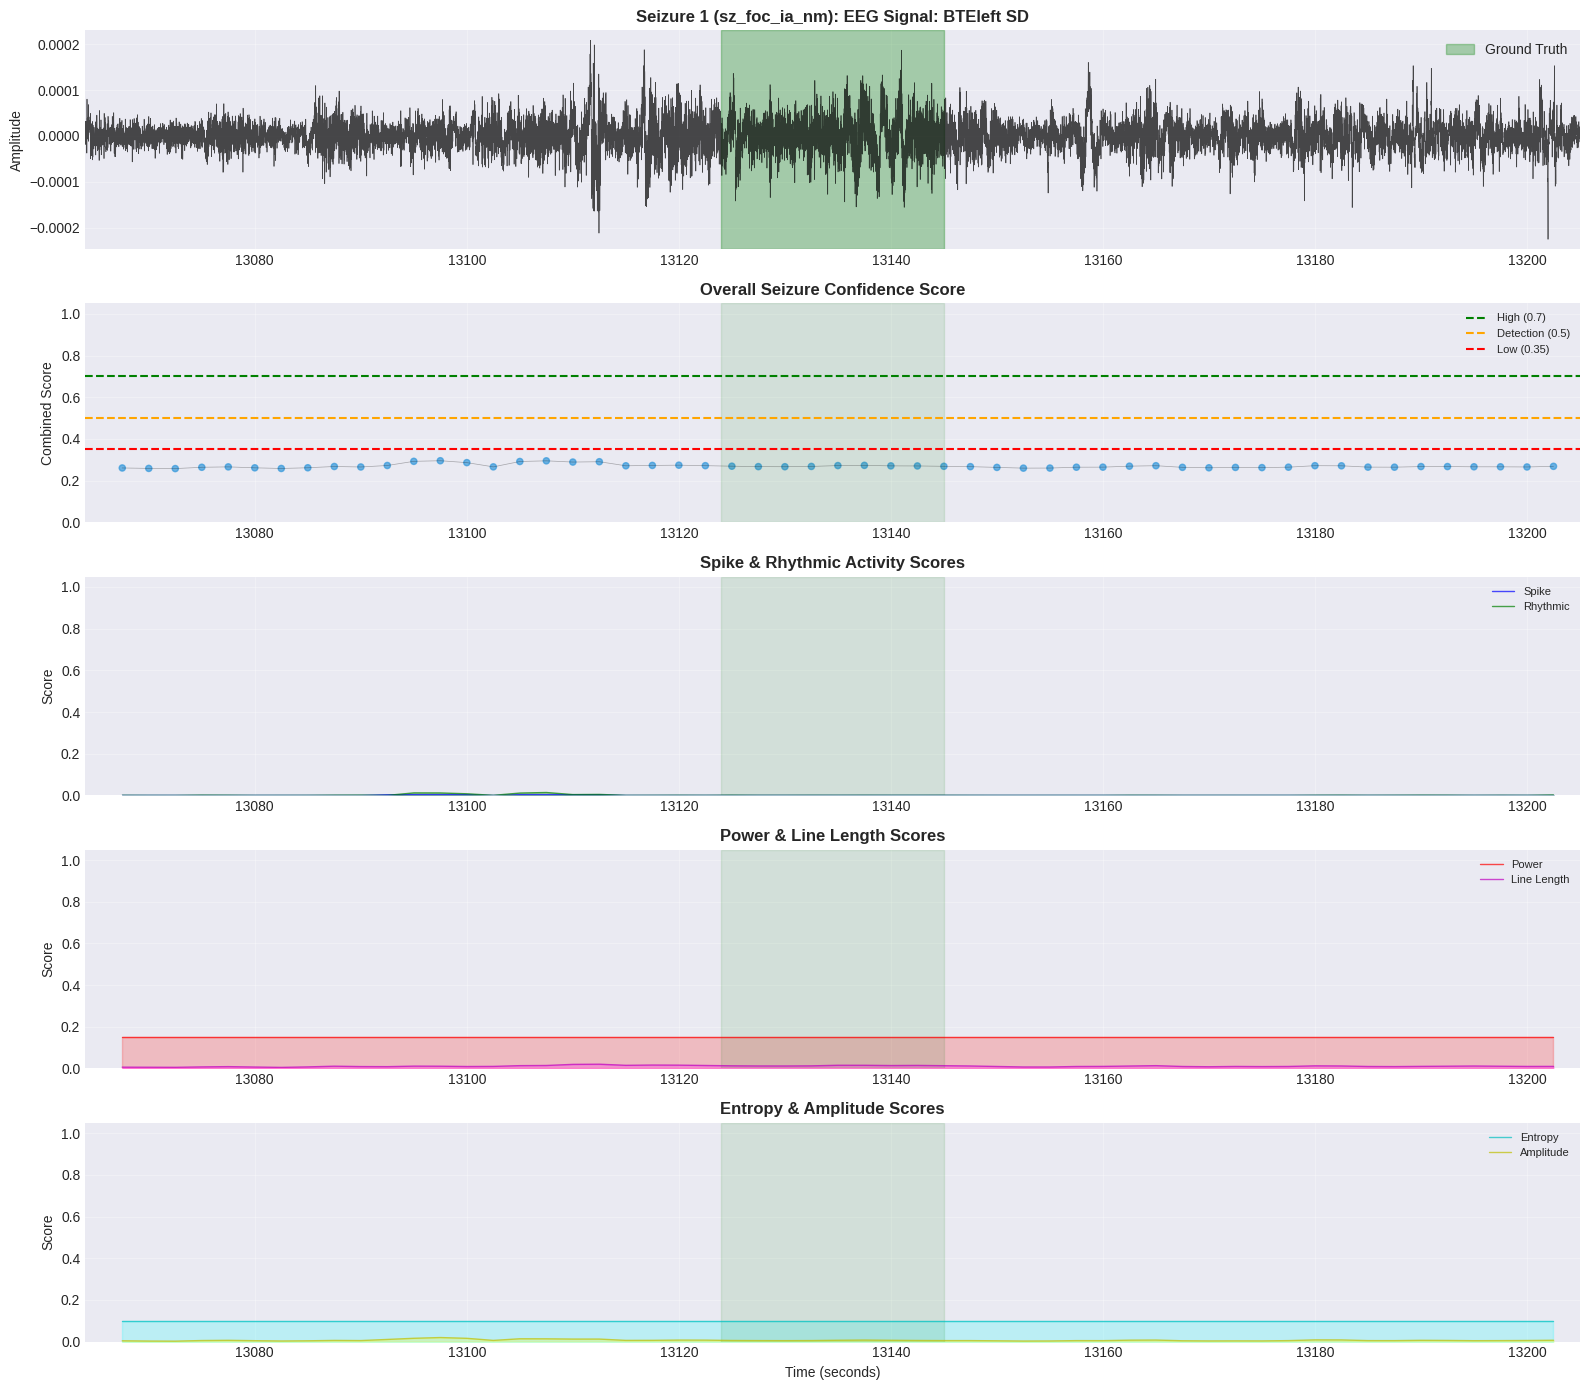


Visualizing Seizure 2: sz_foc_ia_nm
  Time: 43588.0s - 43609.0s
  Duration: 21.0s


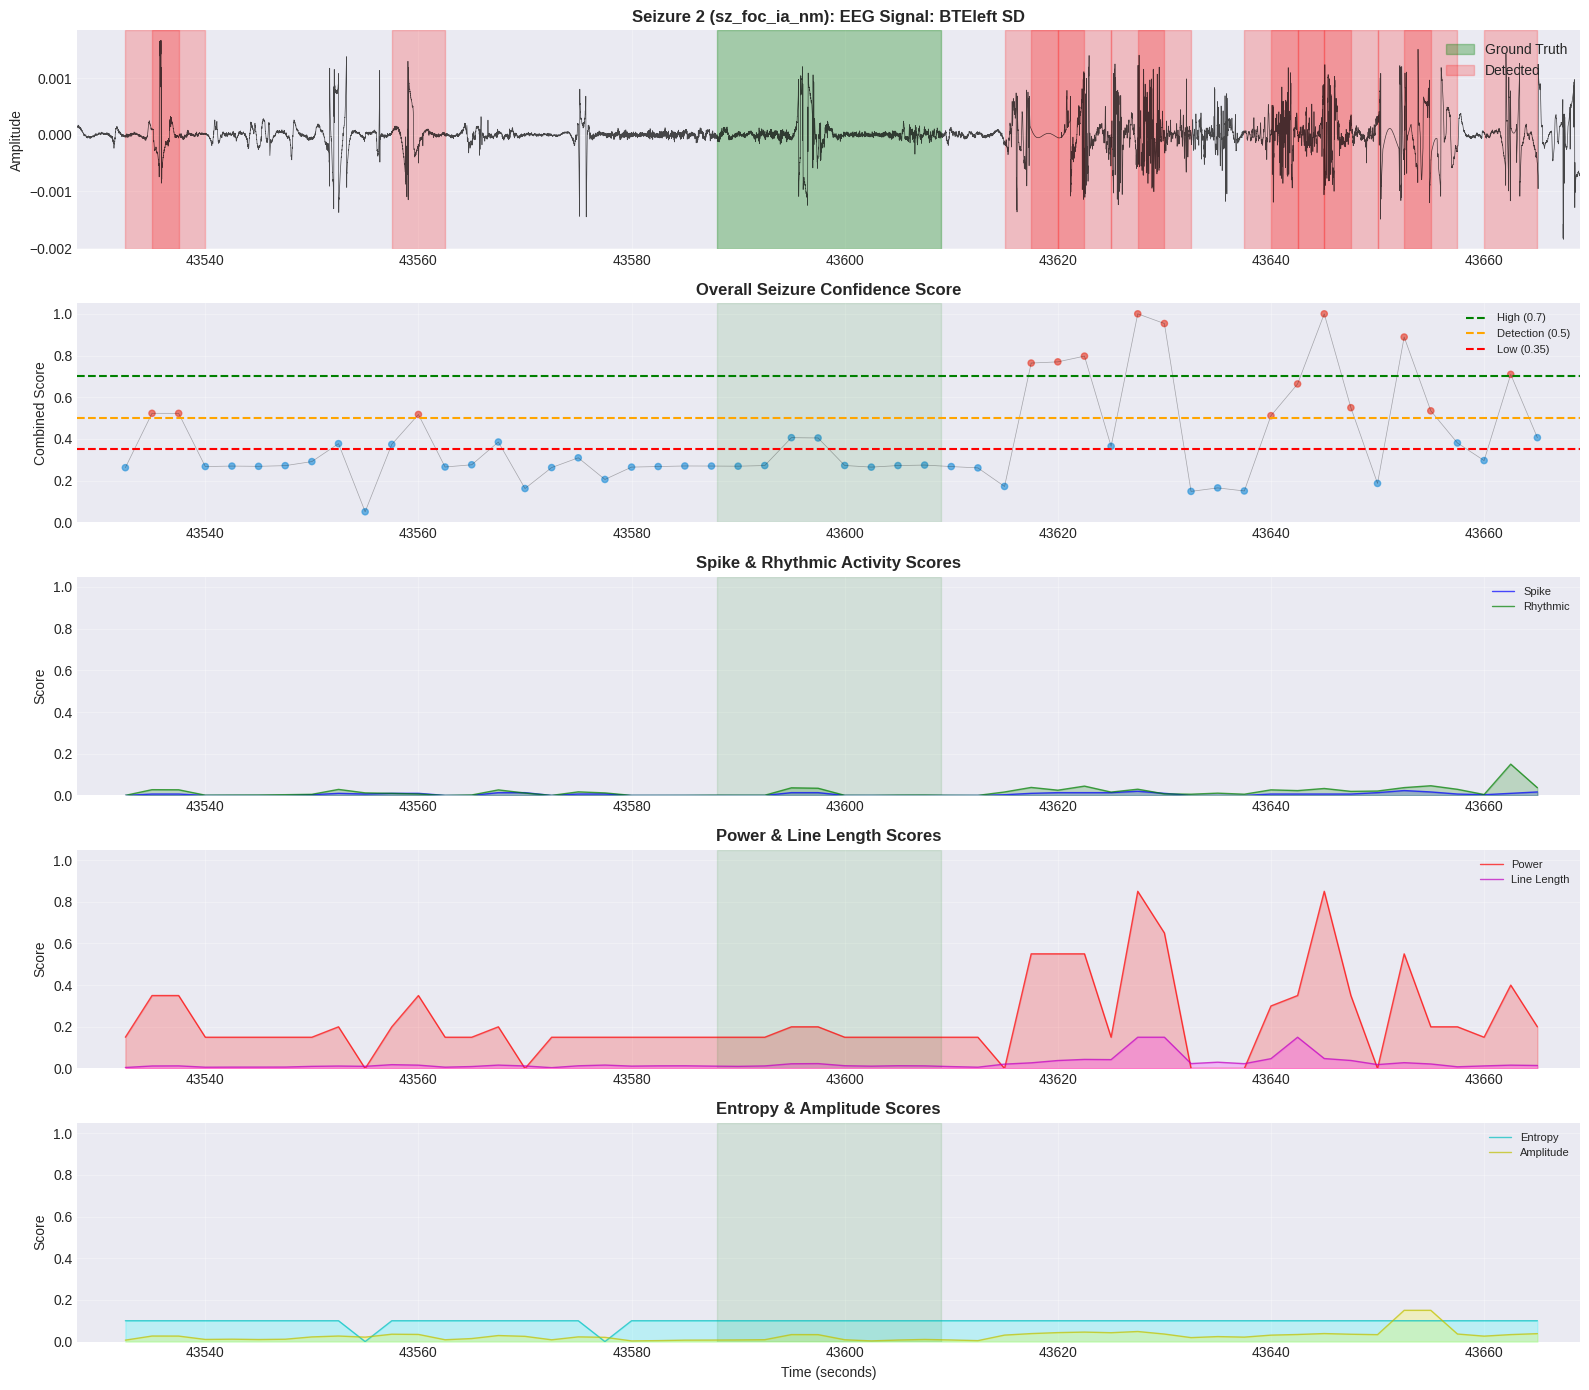

In [35]:
def plot_detection_analysis(results_df: pd.DataFrame, data: np.ndarray,
                           times: np.ndarray, channel_names: List[str],
                           annotations: Optional[EventAnnotations] = None,
                           time_range: Optional[Tuple[float, float]] = None,
                           title_prefix: str = ""):
    """
    Enhanced visualization showing component score breakdown.

    Parameters:
    -----------
    results_df : pd.DataFrame
        Detection results with component scores
    data : np.ndarray
        EEG data
    times : np.ndarray
        Time array
    channel_names : List[str]
        Channel names
    annotations : EventAnnotations, optional
        Ground truth annotations
    time_range : tuple, optional
        (start_time, end_time) to display
    title_prefix : str
        Prefix for plot titles (e.g., filename)
    """
    # Determine time range
    if time_range is None:
        if annotations and len(annotations.events) > 0:
            # Focus around first seizure
            gt = annotations.get_seizure_windows()[0]
            center = (gt['start_time'] + gt['end_time']) / 2
            time_range = (max(0, center - 120), min(times[-1], center + 120))
        else:
            # First 5 minutes
            time_range = (0, min(300, times[-1]))

    fig, axes = plt.subplots(5, 1, figsize=(16, 14))

    # Get indices for time range
    idx_start = np.searchsorted(times, time_range[0])
    idx_end = np.searchsorted(times, time_range[1])

    # Filter results for time range
    mask = (results_df['start_time'] >= time_range[0]) & (results_df['end_time'] <= time_range[1])
    filtered_results = results_df[mask]
    window_centers = (filtered_results['start_time'] + filtered_results['end_time']) / 2

    # =========================================================================
    # Plot 1: EEG Signal with ground truth and detections
    # =========================================================================
    ax1 = axes[0]
    ax1.plot(times[idx_start:idx_end], data[0, idx_start:idx_end], 'k-', linewidth=0.5, alpha=0.7)

    # Ground truth (green)
    if annotations and len(annotations.events) > 0:
        for gt in annotations.get_seizure_windows():
            if gt['start_time'] < time_range[1] and gt['end_time'] > time_range[0]:
                ax1.axvspan(max(gt['start_time'], time_range[0]),
                           min(gt['end_time'], time_range[1]),
                           alpha=0.3, color='green', label='Ground Truth')

    # Detections (red)
    for _, row in filtered_results[filtered_results['seizure_detected']].iterrows():
        ax1.axvspan(row['start_time'], row['end_time'], alpha=0.2, color='red', label='Detected')

    handles, labels = ax1.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    if by_label:
        ax1.legend(by_label.values(), by_label.keys(), loc='upper right')
    ax1.set_ylabel('Amplitude')
    ax1.set_title(f'{title_prefix}EEG Signal: {channel_names[0]}', fontweight='bold')
    ax1.set_xlim(time_range)
    ax1.grid(True, alpha=0.3)

    # =========================================================================
    # Plot 2: Combined Confidence Score
    # =========================================================================
    ax2 = axes[1]
    colors = ['#e74c3c' if d else '#3498db' for d in filtered_results['seizure_detected']]
    ax2.scatter(window_centers, filtered_results['confidence_score'], c=colors, s=20, alpha=0.7)
    ax2.plot(window_centers, filtered_results['confidence_score'], 'k-', alpha=0.3, linewidth=0.5)

    ax2.axhline(y=0.7, color='green', linestyle='--', label='High (0.7)', linewidth=1.5)
    ax2.axhline(y=0.5, color='orange', linestyle='--', label='Detection (0.5)', linewidth=1.5)
    ax2.axhline(y=0.35, color='red', linestyle='--', label='Low (0.35)', linewidth=1.5)

    # Shade ground truth
    if annotations and len(annotations.events) > 0:
        for gt in annotations.get_seizure_windows():
            if gt['start_time'] < time_range[1] and gt['end_time'] > time_range[0]:
                ax2.axvspan(max(gt['start_time'], time_range[0]),
                           min(gt['end_time'], time_range[1]), alpha=0.1, color='green')

    ax2.set_ylabel('Combined Score')
    ax2.set_title('Overall Seizure Confidence Score', fontweight='bold')
    ax2.legend(loc='upper right', fontsize=8)
    ax2.set_ylim(0, 1.05)
    ax2.set_xlim(time_range)
    ax2.grid(True, alpha=0.3)

    # =========================================================================
    # Plot 3: Component Scores - Spike and Rhythmic
    # =========================================================================
    ax3 = axes[2]
    ax3.plot(window_centers, filtered_results['score_spike'], 'b-', label='Spike', alpha=0.7, linewidth=1)
    ax3.plot(window_centers, filtered_results['score_rhythmic'], 'g-', label='Rhythmic', alpha=0.7, linewidth=1)
    ax3.fill_between(window_centers, 0, filtered_results['score_spike'], alpha=0.2, color='blue')
    ax3.fill_between(window_centers, 0, filtered_results['score_rhythmic'], alpha=0.2, color='green')

    if annotations and len(annotations.events) > 0:
        for gt in annotations.get_seizure_windows():
            if gt['start_time'] < time_range[1] and gt['end_time'] > time_range[0]:
                ax3.axvspan(max(gt['start_time'], time_range[0]),
                           min(gt['end_time'], time_range[1]), alpha=0.1, color='green')

    ax3.set_ylabel('Score')
    ax3.set_title('Spike & Rhythmic Activity Scores', fontweight='bold')
    ax3.legend(loc='upper right', fontsize=8)
    ax3.set_ylim(0, 1.05)
    ax3.set_xlim(time_range)
    ax3.grid(True, alpha=0.3)

    # =========================================================================
    # Plot 4: Component Scores - Power and Line Length
    # =========================================================================
    ax4 = axes[3]
    ax4.plot(window_centers, filtered_results['score_power'], 'r-', label='Power', alpha=0.7, linewidth=1)
    ax4.plot(window_centers, filtered_results['score_line_length'], 'm-', label='Line Length', alpha=0.7, linewidth=1)
    ax4.fill_between(window_centers, 0, filtered_results['score_power'], alpha=0.2, color='red')
    ax4.fill_between(window_centers, 0, filtered_results['score_line_length'], alpha=0.2, color='magenta')

    if annotations and len(annotations.events) > 0:
        for gt in annotations.get_seizure_windows():
            if gt['start_time'] < time_range[1] and gt['end_time'] > time_range[0]:
                ax4.axvspan(max(gt['start_time'], time_range[0]),
                           min(gt['end_time'], time_range[1]), alpha=0.1, color='green')

    ax4.set_ylabel('Score')
    ax4.set_title('Power & Line Length Scores', fontweight='bold')
    ax4.legend(loc='upper right', fontsize=8)
    ax4.set_ylim(0, 1.05)
    ax4.set_xlim(time_range)
    ax4.grid(True, alpha=0.3)

    # =========================================================================
    # Plot 5: Component Scores - Entropy and Amplitude
    # =========================================================================
    ax5 = axes[4]
    ax5.plot(window_centers, filtered_results['score_entropy'], 'c-', label='Entropy', alpha=0.7, linewidth=1)
    ax5.plot(window_centers, filtered_results['score_amplitude'], 'y-', label='Amplitude', alpha=0.7, linewidth=1)
    ax5.fill_between(window_centers, 0, filtered_results['score_entropy'], alpha=0.2, color='cyan')
    ax5.fill_between(window_centers, 0, filtered_results['score_amplitude'], alpha=0.2, color='yellow')

    if annotations and len(annotations.events) > 0:
        for gt in annotations.get_seizure_windows():
            if gt['start_time'] < time_range[1] and gt['end_time'] > time_range[0]:
                ax5.axvspan(max(gt['start_time'], time_range[0]),
                           min(gt['end_time'], time_range[1]), alpha=0.1, color='green')

    ax5.set_ylabel('Score')
    ax5.set_xlabel('Time (seconds)')
    ax5.set_title('Entropy & Amplitude Scores', fontweight='bold')
    ax5.legend(loc='upper right', fontsize=8)
    ax5.set_ylim(0, 1.05)
    ax5.set_xlim(time_range)
    ax5.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_batch_detection_overview(batch_validation: Dict):
    """
    Plot overview of detections across all files from batch validation.

    Parameters:
    -----------
    batch_validation : dict
        Output from batch_validate_all_files()
    """
    if batch_validation is None or 'all_results' not in batch_validation:
        print("No batch results available for visualization")
        return

    all_results = batch_validation['all_results']
    file_validations = batch_validation.get('file_validations', [])

    n_files = len(all_results)
    fig, axes = plt.subplots(n_files, 1, figsize=(16, 4 * n_files))

    if n_files == 1:
        axes = [axes]

    for idx, (results_df, ax) in enumerate(zip(all_results, axes)):
        filename = results_df['filename'].iloc[0] if 'filename' in results_df.columns else f'File {idx+1}'

        window_centers = (results_df['start_time'] + results_df['end_time']) / 2

        # Color by detection status
        colors = ['#e74c3c' if d else '#3498db' for d in results_df['seizure_detected']]
        ax.scatter(window_centers / 3600, results_df['confidence_score'], c=colors, s=5, alpha=0.5)

        # Threshold line
        ax.axhline(y=0.5, color='orange', linestyle='--', alpha=0.7, linewidth=1)

        # Add file stats
        total_windows = len(results_df)
        detected = results_df['seizure_detected'].sum()
        detection_rate = detected / total_windows * 100 if total_windows > 0 else 0

        # Find validation info for this file
        sensitivity_str = ""
        for fv in file_validations:
            if fv['filename'] in filename or filename in fv['filename']:
                sensitivity_str = f", Sens: {fv['validation']['sensitivity']:.0%}"
                break

        ax.set_title(f'{filename} ({detected}/{total_windows} windows = {detection_rate:.1f}%{sensitivity_str})',
                    fontweight='bold', fontsize=10)
        ax.set_ylabel('Confidence')
        ax.set_ylim(0, 1.05)
        ax.grid(True, alpha=0.3)

        if idx == n_files - 1:
            ax.set_xlabel('Time (hours)')

    plt.suptitle('Seizure Detection Confidence Across All Files', fontsize=14, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.show()


def visualize_seizure_around_ground_truth(loader: EEGDataLoader,
                                          data_clean: np.ndarray,
                                          results_df: pd.DataFrame,
                                          seizure_idx: int = 0,
                                          context_seconds: float = 60):
    """
    Visualize detection results around a specific ground truth seizure.

    Parameters:
    -----------
    loader : EEGDataLoader
        Data loader with annotations
    data_clean : np.ndarray
        Preprocessed EEG data
    results_df : pd.DataFrame
        Detection results
    seizure_idx : int
        Index of the seizure to visualize (0-based)
    context_seconds : float
        Seconds of context to show before and after seizure
    """
    if loader.annotations is None or len(loader.annotations.events) == 0:
        print("No ground truth annotations available")
        return

    seizures = loader.annotations.get_seizure_windows()
    if seizure_idx >= len(seizures):
        print(f"Seizure index {seizure_idx} out of range (0-{len(seizures)-1})")
        return

    seizure = seizures[seizure_idx]
    time_range = (
        max(0, seizure['start_time'] - context_seconds),
        min(loader.times[-1], seizure['end_time'] + context_seconds)
    )

    print(f"\nVisualizing Seizure {seizure_idx + 1}: {seizure['event_type']}")
    print(f"  Time: {seizure['start_time']:.1f}s - {seizure['end_time']:.1f}s")
    print(f"  Duration: {seizure['duration']:.1f}s")

    plot_detection_analysis(
        results_df=results_df,
        data=data_clean,
        times=loader.times,
        channel_names=loader.channel_names,
        annotations=loader.annotations,
        time_range=time_range,
        title_prefix=f"Seizure {seizure_idx + 1} ({seizure['event_type']}): "
    )


# Visualize detection results around known seizures
print("\nVisualizing detection results around ground truth seizures...")
if loader.annotations and len(loader.annotations.events) > 0:
    for i in range(len(loader.annotations.events)):
        visualize_seizure_around_ground_truth(
            loader=loader,
            data_clean=data_clean,
            results_df=results_df,
            seizure_idx=i,
            context_seconds=60
        )
else:
    # Show first 5 minutes if no annotations
    plot_detection_analysis(
        results_df=results_df,
        data=data_clean,
        times=loader.times,
        channel_names=loader.channel_names,
        time_range=(0, 300)
    )

## 8a. Validation and Confusion Matrix

Evaluate seizure detection performance with proper confusion matrix and metrics


Running batch validation on all EDF files...

BATCH VALIDATION: 3 FILES

[1/3] Validating: sub-013_ses-01_task-szMonitoring_run-01_eeg.edf
Loaded EDF: 2 channels, 69388.00s duration
Loaded annotations: 2 seizure events found

Seizure Annotations from sub-013_ses-01_task-szMonitoring_run-01_events.txt:

Seizure 1:
  Time: 13124.0s - 13145.0s
  Duration: 21.0s
  Type: sz_foc_ia_nm
  Lateralization: left
  Localization: temp

Seizure 2:
  Time: 43588.0s - 43609.0s
  Duration: 21.0s
  Type: sz_foc_ia_nm
  Lateralization: left
  Localization: temp
Preprocessing...
  Bandpass filter: 0.5-40.0 Hz
  Notch filter: 60.0 Hz
  Using ICA artifact removal (placeholder)
✓ Preprocessing complete
Computing baseline from first 300.0 seconds...
  Baseline RMS: 0.000230
  Baseline STD: 0.000230
  Baseline computed successfully
  Sensitivity: 0.00%, Precision: 0.00%, Events: 0/2
[2/3] Validating: sub-053_ses-01_task-szMonitoring_run-03_eeg.edf
Loaded EDF: 2 channels, 33558.00s duration
Loaded annotations:

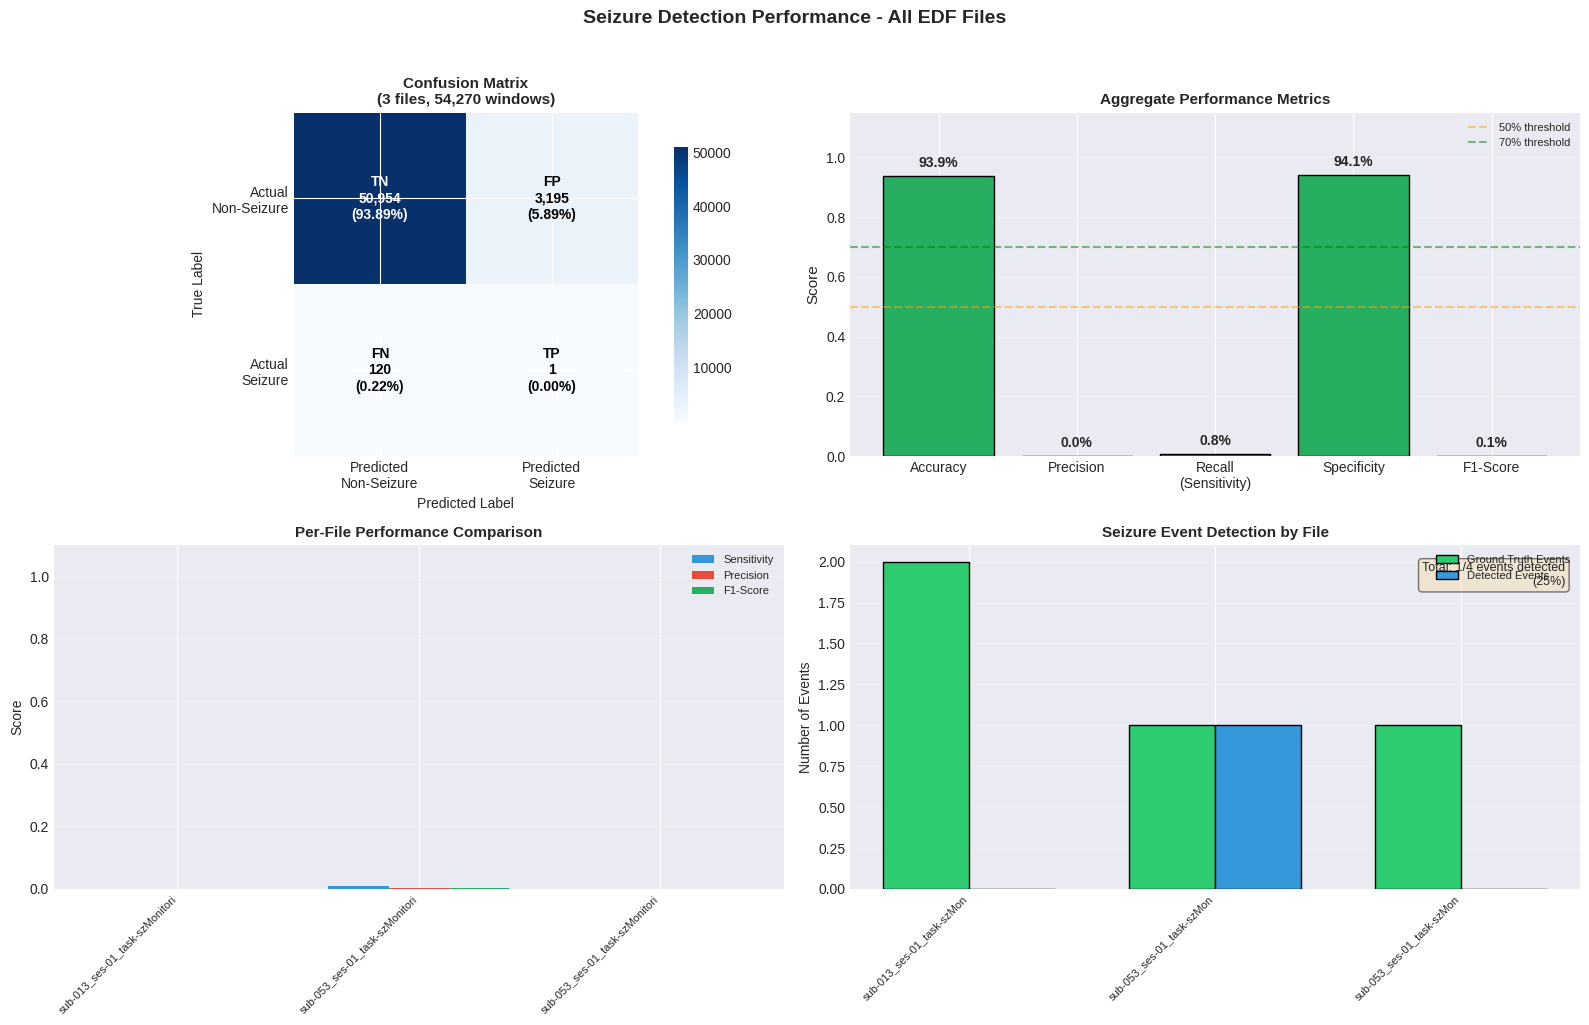


AGGREGATE PERFORMANCE METRICS

Files Analyzed: 3
Total Windows: 54,270

Confusion Matrix Summary:
  True Positives (TP):         1 - Correctly detected seizure windows
  True Negatives (TN):    50,954 - Correctly identified non-seizure windows
  False Positives (FP):    3,195 - Non-seizure windows incorrectly flagged
  False Negatives (FN):      120 - Missed seizure windows

Performance Metrics:
  Accuracy:    93.89%
  Precision:   0.03%
  Recall:      0.83%
  Specificity: 94.10%
  F1-Score:    0.06%

Event-Level Detection:
  Total Ground Truth Events: 4
  Events Detected: 1
  Event Detection Rate: 25.00%


In [36]:
def validate_detections(results_df: pd.DataFrame,
                        annotations: EventAnnotations,
                        overlap_threshold: float = 0.5) -> Dict:
    """
    Validate detections against ground truth annotations

    Parameters:
    -----------
    results_df : pd.DataFrame
        Detection results with columns: start_time, end_time, seizure_detected
    annotations : EventAnnotations
        Ground truth seizure annotations
    overlap_threshold : float
        Minimum overlap ratio required for a match (0-1)

    Returns:
    --------
    validation : dict
        Validation metrics including TP, FP, FN, TN and performance metrics
    """
    if annotations is None or len(annotations.events) == 0:
        print("No ground truth annotations available for validation")
        return None

    ground_truth = annotations.get_seizure_windows()

    # Create binary labels for each window
    window_labels = []  # Ground truth: 1 = seizure, 0 = non-seizure
    window_predictions = []  # Predictions: 1 = seizure, 0 = non-seizure

    for _, row in results_df.iterrows():
        window_start = row['start_time']
        window_end = row['end_time']
        window_duration = window_end - window_start

        # Check if this window overlaps with any ground truth seizure
        is_seizure = False
        for gt in ground_truth:
            gt_start = gt['start_time']
            gt_end = gt['end_time']

            # Calculate overlap
            overlap_start = max(window_start, gt_start)
            overlap_end = min(window_end, gt_end)
            overlap_duration = max(0, overlap_end - overlap_start)
            overlap_ratio = overlap_duration / window_duration

            if overlap_ratio >= overlap_threshold:
                is_seizure = True
                break

        window_labels.append(1 if is_seizure else 0)
        window_predictions.append(1 if row['seizure_detected'] else 0)

    # Convert to numpy arrays
    y_true = np.array(window_labels)
    y_pred = np.array(window_predictions)

    # Calculate confusion matrix components
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    # Calculate metrics
    total = TP + TN + FP + FN
    accuracy = (TP + TN) / total if total > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0  # Sensitivity
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    # Event-based validation (did we detect each seizure event?)
    detected_events = 0
    for gt in ground_truth:
        gt_start = gt['start_time']
        gt_end = gt['end_time']

        # Check if any detected window overlaps with this event
        for _, row in results_df[results_df['seizure_detected']].iterrows():
            overlap_start = max(row['start_time'], gt_start)
            overlap_end = min(row['end_time'], gt_end)
            if overlap_end > overlap_start:
                detected_events += 1
                break

    return {
        'y_true': y_true,
        'y_pred': y_pred,
        'confusion_matrix': {'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN},
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'sensitivity': recall,
        'specificity': specificity,
        'f1_score': f1,
        'true_positives': TP,
        'true_negatives': TN,
        'false_positives': FP,
        'false_negatives': FN,
        'total_windows': total,
        'total_ground_truth': len(ground_truth),
        'detected_events': detected_events,
        'event_detection_rate': detected_events / len(ground_truth) if len(ground_truth) > 0 else 0
    }


def batch_validate_all_files(data_dir: str = 'data',
                             window_size: float = 5.0,
                             detection_threshold: float = 0.50) -> Dict:
    """
    Run validation on all EDF files and aggregate results.

    Returns:
    --------
    aggregate_validation : dict
        Combined validation metrics across all files
    """
    edf_files = EEGDataLoader.list_available_edf_files(data_dir)

    if not edf_files:
        print(f"No EDF files found in {data_dir}")
        return None

    print(f"\n{'='*70}")
    print(f"BATCH VALIDATION: {len(edf_files)} FILES")
    print(f"{'='*70}\n")

    # Aggregate confusion matrix values
    total_TP = 0
    total_TN = 0
    total_FP = 0
    total_FN = 0
    total_ground_truth_events = 0
    total_detected_events = 0

    file_validations = []
    all_results = []  # Store all results for combined analysis

    for i, edf_path in enumerate(edf_files, 1):
        filename = Path(edf_path).name
        print(f"[{i}/{len(edf_files)}] Validating: {filename}")

        try:
            # Load and process
            batch_loader = EEGDataLoader()
            batch_loader.load_from_edf(edf_path)

            batch_preprocessor = Preprocessor(CONFIG['preprocessing'])
            batch_data_clean = batch_preprocessor.preprocess(batch_loader.data, batch_loader.sfreq)

            batch_detector = SeizureDetector(sfreq=batch_loader.sfreq)
            batch_detector.params['detection_threshold'] = detection_threshold
            batch_detector.compute_baseline(batch_data_clean, use_first_minutes=5.0)

            batch_analyzer = SlidingWindowAnalyzer(
                detector=batch_detector,
                window_size=window_size,
                overlap=0.5,
                sfreq=batch_loader.sfreq
            )

            batch_results = batch_analyzer.analyze_recording(batch_data_clean, show_progress=False)

            # Add filename to results for tracking
            batch_results['filename'] = filename
            all_results.append(batch_results)

            # Validate if annotations exist
            if batch_loader.annotations and len(batch_loader.annotations.events) > 0:
                validation = validate_detections(batch_results, batch_loader.annotations)
                if validation:
                    total_TP += validation['true_positives']
                    total_TN += validation['true_negatives']
                    total_FP += validation['false_positives']
                    total_FN += validation['false_negatives']
                    total_ground_truth_events += validation['total_ground_truth']
                    total_detected_events += validation['detected_events']

                    file_validations.append({
                        'filename': filename,
                        'validation': validation,
                        'ground_truth_events': validation['total_ground_truth'],
                        'detected_events': validation['detected_events']
                    })

                    print(f"  Sensitivity: {validation['sensitivity']:.2%}, "
                          f"Precision: {validation['precision']:.2%}, "
                          f"Events: {validation['detected_events']}/{validation['total_ground_truth']}")
            else:
                print(f"  No annotations available for validation")

        except Exception as e:
            print(f"  Error: {e}")

    # Calculate aggregate metrics
    total = total_TP + total_TN + total_FP + total_FN

    aggregate_validation = {
        'confusion_matrix': {'TP': total_TP, 'TN': total_TN, 'FP': total_FP, 'FN': total_FN},
        'accuracy': (total_TP + total_TN) / total if total > 0 else 0,
        'precision': total_TP / (total_TP + total_FP) if (total_TP + total_FP) > 0 else 0,
        'recall': total_TP / (total_TP + total_FN) if (total_TP + total_FN) > 0 else 0,
        'sensitivity': total_TP / (total_TP + total_FN) if (total_TP + total_FN) > 0 else 0,
        'specificity': total_TN / (total_TN + total_FP) if (total_TN + total_FP) > 0 else 0,
        'f1_score': 2 * total_TP / (2 * total_TP + total_FP + total_FN) if (2 * total_TP + total_FP + total_FN) > 0 else 0,
        'true_positives': total_TP,
        'true_negatives': total_TN,
        'false_positives': total_FP,
        'false_negatives': total_FN,
        'total_windows': total,
        'total_ground_truth_events': total_ground_truth_events,
        'total_detected_events': total_detected_events,
        'event_detection_rate': total_detected_events / total_ground_truth_events if total_ground_truth_events > 0 else 0,
        'file_validations': file_validations,
        'all_results': all_results,
        'num_files': len(edf_files)
    }

    return aggregate_validation


def plot_batch_confusion_matrix(validation: Dict, title: str = "Aggregate Seizure Detection - All Files"):
    """
    Create confusion matrix visualization for batch/aggregate results.

    Parameters:
    -----------
    validation : dict
        Output from batch_validate_all_files() or validate_detections()
    title : str
        Title for the plot
    """
    if validation is None:
        print("No validation data available")
        return

    cm = validation['confusion_matrix']

    # Create confusion matrix array
    matrix = np.array([
        [cm['TN'], cm['FP']],
        [cm['FN'], cm['TP']]
    ])

    # Calculate percentages
    total = matrix.sum()
    percentages = matrix / total * 100 if total > 0 else matrix

    # Create figure with subplots
    fig = plt.figure(figsize=(16, 10))

    # =========================================================================
    # Plot 1: Confusion Matrix Heatmap
    # =========================================================================
    ax1 = fig.add_subplot(2, 2, 1)
    im = ax1.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax1.figure.colorbar(im, ax=ax1, shrink=0.8)

    ax1.set(xticks=np.arange(matrix.shape[1]),
           yticks=np.arange(matrix.shape[0]),
           xticklabels=['Predicted\nNon-Seizure', 'Predicted\nSeizure'],
           yticklabels=['Actual\nNon-Seizure', 'Actual\nSeizure'],
           ylabel='True Label',
           xlabel='Predicted Label')

    # Add text annotations
    thresh = matrix.max() / 2.
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            cell_value = matrix[i, j]
            pct = percentages[i, j]
            cell_label = ['TN', 'FP', 'FN', 'TP'][i * 2 + j]
            ax1.text(j, i, f'{cell_label}\n{cell_value:,.0f}\n({pct:.2f}%)',
                    ha="center", va="center",
                    color="white" if cell_value > thresh else "black",
                    fontsize=10, fontweight='bold')

    ax1.set_title(f'Confusion Matrix\n({validation.get("num_files", 1)} files, {total:,} windows)',
                  fontsize=11, fontweight='bold')

    # =========================================================================
    # Plot 2: Performance Metrics Bar Chart
    # =========================================================================
    ax2 = fig.add_subplot(2, 2, 2)
    metrics = ['Accuracy', 'Precision', 'Recall\n(Sensitivity)', 'Specificity', 'F1-Score']
    values = [
        validation['accuracy'],
        validation['precision'],
        validation['recall'],
        validation['specificity'],
        validation['f1_score']
    ]

    colors = ['#27ae60' if v >= 0.7 else '#f39c12' if v >= 0.5 else '#e74c3c' for v in values]
    bars = ax2.bar(metrics, values, color=colors, edgecolor='black', linewidth=1)

    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{val:.1%}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax2.set_ylim(0, 1.15)
    ax2.set_ylabel('Score', fontsize=11)
    ax2.set_title('Aggregate Performance Metrics', fontsize=11, fontweight='bold')
    ax2.axhline(y=0.5, color='orange', linestyle='--', alpha=0.5, label='50% threshold')
    ax2.axhline(y=0.7, color='green', linestyle='--', alpha=0.5, label='70% threshold')
    ax2.legend(loc='upper right', fontsize=8)
    ax2.grid(True, alpha=0.3, axis='y')

    # =========================================================================
    # Plot 3: Per-File Performance Comparison
    # =========================================================================
    if 'file_validations' in validation and len(validation['file_validations']) > 0:
        ax3 = fig.add_subplot(2, 2, 3)

        file_names = [fv['filename'][:30] for fv in validation['file_validations']]
        sensitivities = [fv['validation']['sensitivity'] for fv in validation['file_validations']]
        precisions = [fv['validation']['precision'] for fv in validation['file_validations']]
        f1_scores = [fv['validation']['f1_score'] for fv in validation['file_validations']]

        x = np.arange(len(file_names))
        width = 0.25

        bars1 = ax3.bar(x - width, sensitivities, width, label='Sensitivity', color='#3498db')
        bars2 = ax3.bar(x, precisions, width, label='Precision', color='#e74c3c')
        bars3 = ax3.bar(x + width, f1_scores, width, label='F1-Score', color='#27ae60')

        ax3.set_ylabel('Score')
        ax3.set_title('Per-File Performance Comparison', fontsize=11, fontweight='bold')
        ax3.set_xticks(x)
        ax3.set_xticklabels(file_names, rotation=45, ha='right', fontsize=8)
        ax3.legend(loc='upper right', fontsize=8)
        ax3.set_ylim(0, 1.1)
        ax3.grid(True, alpha=0.3, axis='y')

        # Add value labels
        for bars in [bars1, bars2, bars3]:
            for bar in bars:
                height = bar.get_height()
                if height > 0.05:
                    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                            f'{height:.0%}', ha='center', va='bottom', fontsize=7)

    # =========================================================================
    # Plot 4: Event Detection Summary
    # =========================================================================
    ax4 = fig.add_subplot(2, 2, 4)

    if 'file_validations' in validation and len(validation['file_validations']) > 0:
        file_names = [fv['filename'][:25] for fv in validation['file_validations']]
        ground_truth = [fv['ground_truth_events'] for fv in validation['file_validations']]
        detected = [fv['detected_events'] for fv in validation['file_validations']]

        x = np.arange(len(file_names))
        width = 0.35

        bars1 = ax4.bar(x - width/2, ground_truth, width, label='Ground Truth Events', color='#2ecc71', edgecolor='black')
        bars2 = ax4.bar(x + width/2, detected, width, label='Detected Events', color='#3498db', edgecolor='black')

        ax4.set_ylabel('Number of Events')
        ax4.set_title('Seizure Event Detection by File', fontsize=11, fontweight='bold')
        ax4.set_xticks(x)
        ax4.set_xticklabels(file_names, rotation=45, ha='right', fontsize=8)
        ax4.legend(loc='upper right', fontsize=8)
        ax4.grid(True, alpha=0.3, axis='y')

        # Add total annotation
        total_gt = validation['total_ground_truth_events']
        total_det = validation['total_detected_events']
        ax4.text(0.98, 0.95, f'Total: {total_det}/{total_gt} events detected\n({validation["event_detection_rate"]:.0%})',
                transform=ax4.transAxes, ha='right', va='top', fontsize=9,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    else:
        # Single file case
        ax4.text(0.5, 0.5, f'Ground Truth Events: {validation.get("total_ground_truth", "N/A")}\n'
                          f'Detected Events: {validation.get("detected_events", "N/A")}\n'
                          f'Detection Rate: {validation.get("event_detection_rate", 0):.0%}',
                transform=ax4.transAxes, ha='center', va='center', fontsize=12)
        ax4.set_title('Event Detection Summary', fontsize=11, fontweight='bold')

    plt.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

    # Print detailed metrics
    print("\n" + "="*70)
    print("AGGREGATE PERFORMANCE METRICS")
    print("="*70)
    print(f"\nFiles Analyzed: {validation.get('num_files', 1)}")
    print(f"Total Windows: {validation['total_windows']:,}")
    print(f"\nConfusion Matrix Summary:")
    print(f"  True Positives (TP):  {cm['TP']:>8,} - Correctly detected seizure windows")
    print(f"  True Negatives (TN):  {cm['TN']:>8,} - Correctly identified non-seizure windows")
    print(f"  False Positives (FP): {cm['FP']:>8,} - Non-seizure windows incorrectly flagged")
    print(f"  False Negatives (FN): {cm['FN']:>8,} - Missed seizure windows")
    print(f"\nPerformance Metrics:")
    print(f"  Accuracy:    {validation['accuracy']:.2%}")
    print(f"  Precision:   {validation['precision']:.2%}")
    print(f"  Recall:      {validation['recall']:.2%}")
    print(f"  Specificity: {validation['specificity']:.2%}")
    print(f"  F1-Score:    {validation['f1_score']:.2%}")
    print(f"\nEvent-Level Detection:")
    print(f"  Total Ground Truth Events: {validation.get('total_ground_truth_events', validation.get('total_ground_truth', 'N/A'))}")
    print(f"  Events Detected: {validation.get('total_detected_events', validation.get('detected_events', 'N/A'))}")
    print(f"  Event Detection Rate: {validation.get('event_detection_rate', 0):.2%}")


# Run batch validation on all files
print("\nRunning batch validation on all EDF files...")
batch_validation = batch_validate_all_files(
    data_dir='data',
    window_size=5.0,
    detection_threshold=0.50
)

# Plot aggregate confusion matrix
if batch_validation:
    plot_batch_confusion_matrix(batch_validation, title="Seizure Detection Performance - All EDF Files")

## 9. Export Results

Export detection results and generate final report

In [37]:
def export_results(results_df: pd.DataFrame, report: Dict, output_prefix: str = 'seizure_detection'):
    """Export results to files"""

    # Save detailed window results
    csv_path = f"{output_prefix}_windows.csv"
    results_df.to_csv(csv_path, index=False)
    print(f"Saved detailed results to {csv_path}")

    # Save event summary
    if report['seizure_events']:
        events_df = pd.DataFrame(report['seizure_events'])
        events_path = f"{output_prefix}_events.csv"
        events_df.to_csv(events_path, index=False)
        print(f"Saved seizure events to {events_path}")

    # Generate text report
    report_path = f"{output_prefix}_report.txt"
    with open(report_path, 'w') as f:
        f.write("="*70 + "\n")
        f.write("SEIZURE DETECTION ANALYSIS REPORT\n")
        f.write("="*70 + "\n\n")

        f.write(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")

        f.write("CONFIGURATION:\n")
        f.write("-"*70 + "\n")
        for key, value in CONFIG.items():
            f.write(f"{key}: {value}\n")
        f.write("\n")

        f.write("SUMMARY:\n")
        f.write("-"*70 + "\n")
        f.write(f"Total Recording Duration: {report['total_duration']:.2f} seconds\n")
        f.write(f"Total Windows Analyzed: {report['total_windows']}\n")
        f.write(f"Windows with Seizure Activity: {report['seizures_detected']}\n")
        f.write(f"Detection Rate: {report['detection_rate']:.2%}\n")
        f.write(f"Number of Seizure Events: {report['num_events']}\n\n")

        if report['seizure_events']:
            f.write("DETECTED SEIZURE EVENTS:\n")
            f.write("-"*70 + "\n")
            for i, event in enumerate(report['seizure_events'], 1):
                f.write(f"\nEvent {i}:\n")
                f.write(f"  Seizure Type: {event.get('seizure_type', 'unknown')}\n")
                f.write(f"  Start Time: {event['start_time']:.2f}s\n")
                f.write(f"  End Time: {event['end_time']:.2f}s\n")
                f.write(f"  Duration: {event['duration']:.2f}s\n")
                f.write(f"  Confidence: {event['max_confidence']:.2%}\n")
                # Include component scores if available
                if 'component_scores' in event:
                    f.write(f"  Component Scores:\n")
                    for score_name, score_val in event['component_scores'].items():
                        f.write(f"    {score_name}: {score_val:.3f}\n")
        else:
            f.write("\nNo seizure events detected.\n")

    print(f"Saved report to {report_path}")
    print("\nExport complete!")

# Export results
export_results(results_df, report, output_prefix='seizure_detection_test')

Saved detailed results to seizure_detection_test_windows.csv
Saved seizure events to seizure_detection_test_events.csv
Saved report to seizure_detection_test_report.txt

Export complete!


## Next Steps & Usage Guide

### Your Data is Now Integrated!

The notebook is now configured to work with your real EEG data in the `data/` directory:
- ✓ Automatically loads EDF files
- ✓ Parses seizure event annotations
- ✓ Validates detections against ground truth
- ✓ Supports batch processing of multiple files

### Quick Start Guide:

**1. Analyze a single file:**
```python
# The notebook already loads the first file by default
# To load a different file, modify cell 6:
loader.load_from_edf('data/sub-053_ses-01_task-szMonitoring_run-03_eeg.edf')
```

**2. Run batch analysis on all files:**
```python
# Uncomment the batch analysis code in the last cell, or run:
batch_summary = batch_analyze_edf_files(
    data_dir='data',
    window_size=5.0,
    high_threshold=0.50,  # Adjust threshold as needed
    export_results=True
)
```

**3. Optimize detection parameters:**
```python
# Test different configurations
results, report = quick_test_pipeline(
    data_source='edf',
    edf_path='data/sub-013_ses-01_task-szMonitoring_run-01_eeg.edf',
    window_size=3.0,      # Try different window sizes
    high_threshold=0.40   # Adjust sensitivity
)
```

### Improving Detection Performance:

**Current Status:**
- The notebook uses generic seizure prototypes
- Detection may miss seizures or have low sensitivity
- This is expected with placeholder prototypes

**To Improve:**

1. **Train Custom Prototypes** - Extract features from known seizure windows:
```python
# Extract features from annotated seizures
seizure_windows = loader.annotations.get_seizure_windows()
for window in seizure_windows:
    start_idx = int(window['start_time'] * loader.sfreq)
    end_idx = int(window['end_time'] * loader.sfreq)
    seizure_data = data_clean[:, start_idx:end_idx]
    features = extractor.extract_all_features(seizure_data)
    # Build prototype from these features
```

2. **Adjust Thresholds** - Lower thresholds increase sensitivity:
```python
CONFIG['thresholds']['high_confidence'] = 0.40  # Lower = more detections
CONFIG['thresholds']['medium_confidence'] = 0.25
```

3. **Tune Window Size** - Match to expected seizure duration:
```python
CONFIG['pattern_matching']['window_size'] = 3.0  # Try 3-10 seconds
```

4. **Add Domain-Specific Features** - For focal seizures:
   - Asymmetry indices between hemispheres
   - Spike detection algorithms
   - Phase synchronization measures

### Available Data Files:

Your data directory contains:
- `sub-013_ses-01_task-szMonitoring_run-01_eeg.edf` - 2 focal seizures (left temporal)
- `sub-053_ses-01_task-szMonitoring_run-03_eeg.edf` - 1 focal seizure
- `sub-053_ses-01_task-szMonitoring_run-04_eeg.edf` - 1 focal seizure (right temporal)

All files have corresponding `*_events.txt` annotation files that are automatically loaded.

### Output Files:

The pipeline generates:
- `*_windows.csv` - Detailed detection results for each window
- `*_events.csv` - Summary of detected seizure events
- `*_report.txt` - Human-readable analysis report
- `batch_analysis_summary.csv` - Summary across all files (batch mode)

### Troubleshooting:

- **No seizures detected**: Lower the threshold or adjust window size
- **Too many false positives**: Increase threshold or refine prototypes
- **Memory issues**: Process files one at a time or reduce sampling rate
- **Channel localization issues**: Update `ChannelLocalizer.HEMISPHERE_MAP` for your electrode layout

In [38]:
def batch_analyze_edf_files(data_dir: str = 'data',
                           window_size: float = 5.0,
                           detection_threshold: float = 0.50,
                           export_results: bool = True):
    """
    Analyze all EDF files in the data directory using the real signal analysis detector.

    Parameters:
    -----------
    data_dir : str
        Directory containing EDF files
    window_size : float
        Analysis window size in seconds
    detection_threshold : float
        Detection threshold for combined score
    export_results : bool
        Whether to export individual reports

    Returns:
    --------
    summary_df : pd.DataFrame
        Summary of all analyses
    """

    edf_files = EEGDataLoader.list_available_edf_files(data_dir)

    if not edf_files:
        print(f"No EDF files found in {data_dir}")
        return None

    print(f"\n{'='*70}")
    print(f"BATCH ANALYSIS: {len(edf_files)} FILES")
    print(f"{'='*70}\n")

    summary_data = []

    for i, edf_path in enumerate(edf_files, 1):
        filename = Path(edf_path).name
        print(f"\n[{i}/{len(edf_files)}] Processing: {filename}")
        print("-" * 70)

        try:
            # Load data
            batch_loader = EEGDataLoader()
            batch_loader.load_from_edf(edf_path)

            # Preprocess
            print("  Preprocessing...")
            batch_preprocessor = Preprocessor(CONFIG['preprocessing'])
            batch_data_clean = batch_preprocessor.preprocess(batch_loader.data, batch_loader.sfreq)

            # Setup detector with new real signal analysis
            print("  Setting up seizure detector...")
            batch_detector = SeizureDetector(sfreq=batch_loader.sfreq)
            batch_detector.params['detection_threshold'] = detection_threshold
            batch_detector.compute_baseline(batch_data_clean, use_first_minutes=5.0)

            # Analyze
            print("  Running detection...")
            batch_analyzer = SlidingWindowAnalyzer(
                detector=batch_detector,
                window_size=window_size,
                overlap=0.5,
                sfreq=batch_loader.sfreq
            )

            batch_results = batch_analyzer.analyze_recording(batch_data_clean, show_progress=False)
            batch_report = batch_analyzer.generate_report(batch_results)

            # Validation
            sensitivity = None
            true_positives = 0
            total_ground_truth = 0

            if batch_loader.annotations and len(batch_loader.annotations.events) > 0:
                validation = validate_detections(batch_results, batch_loader.annotations)
                if validation:
                    sensitivity = validation['sensitivity']
                    true_positives = validation['true_positives']
                    total_ground_truth = validation['total_ground_truth']

            # Export if requested
            if export_results:
                output_prefix = f"results/{Path(edf_path).stem}"
                Path("results").mkdir(exist_ok=True)
                batch_results.to_csv(f"{output_prefix}_windows.csv", index=False)
                print(f"  Exported to {output_prefix}_windows.csv")

            # Collect summary
            summary_data.append({
                'filename': filename,
                'duration_sec': batch_loader.times[-1],
                'n_channels': len(batch_loader.channel_names),
                'ground_truth_seizures': total_ground_truth,
                'detected_events': batch_report['num_events'],
                'detection_windows': batch_report['seizures_detected'],
                'true_positives': true_positives,
                'sensitivity': sensitivity,
                'detection_rate': batch_report['detection_rate']
            })

            print(f"  Complete - Detected: {batch_report['num_events']} events")

        except Exception as e:
            print(f"  Error processing {filename}: {e}")
            import traceback
            traceback.print_exc()
            summary_data.append({
                'filename': filename,
                'error': str(e)
            })

    # Create summary DataFrame
    summary_df = pd.DataFrame(summary_data)

    # Display summary
    print(f"\n{'='*70}")
    print("BATCH ANALYSIS SUMMARY")
    print(f"{'='*70}\n")
    print(summary_df.to_string(index=False))

    # Calculate overall statistics
    if 'sensitivity' in summary_df.columns:
        valid_sensitivities = summary_df['sensitivity'].dropna()
        if len(valid_sensitivities) > 0:
            print(f"\n{'='*70}")
            print(f"Overall Sensitivity (across all files): {valid_sensitivities.mean():.2%}")
            print(f"Total True Positives: {summary_df['true_positives'].sum()}")
            print(f"Total Ground Truth Seizures: {summary_df['ground_truth_seizures'].sum()}")

    # Save summary
    Path("results").mkdir(exist_ok=True)
    summary_df.to_csv('results/batch_analysis_summary.csv', index=False)
    print(f"\nSummary saved to results/batch_analysis_summary.csv")

    return summary_df

# Run batch analysis on all EDF files
print("Running batch analysis on all EDF files in data/ directory...")
batch_summary = batch_analyze_edf_files(
    data_dir='data',
    window_size=5.0,
    detection_threshold=0.50,
    export_results=True
)

Running batch analysis on all EDF files in data/ directory...

BATCH ANALYSIS: 3 FILES


[1/3] Processing: sub-013_ses-01_task-szMonitoring_run-01_eeg.edf
----------------------------------------------------------------------
Loaded EDF: 2 channels, 69388.00s duration
Loaded annotations: 2 seizure events found

Seizure Annotations from sub-013_ses-01_task-szMonitoring_run-01_events.txt:

Seizure 1:
  Time: 13124.0s - 13145.0s
  Duration: 21.0s
  Type: sz_foc_ia_nm
  Lateralization: left
  Localization: temp

Seizure 2:
  Time: 43588.0s - 43609.0s
  Duration: 21.0s
  Type: sz_foc_ia_nm
  Lateralization: left
  Localization: temp
  Preprocessing...
Preprocessing...
  Bandpass filter: 0.5-40.0 Hz
  Notch filter: 60.0 Hz
  Using ICA artifact removal (placeholder)
✓ Preprocessing complete
  Setting up seizure detector...
Computing baseline from first 300.0 seconds...
  Baseline RMS: 0.000230
  Baseline STD: 0.000230
  Baseline computed successfully
  Running detection...
  Exported to resul

## 10. Batch Results Visualization

Visualize aggregate results across all analyzed EDF files


BATCH VISUALIZATION


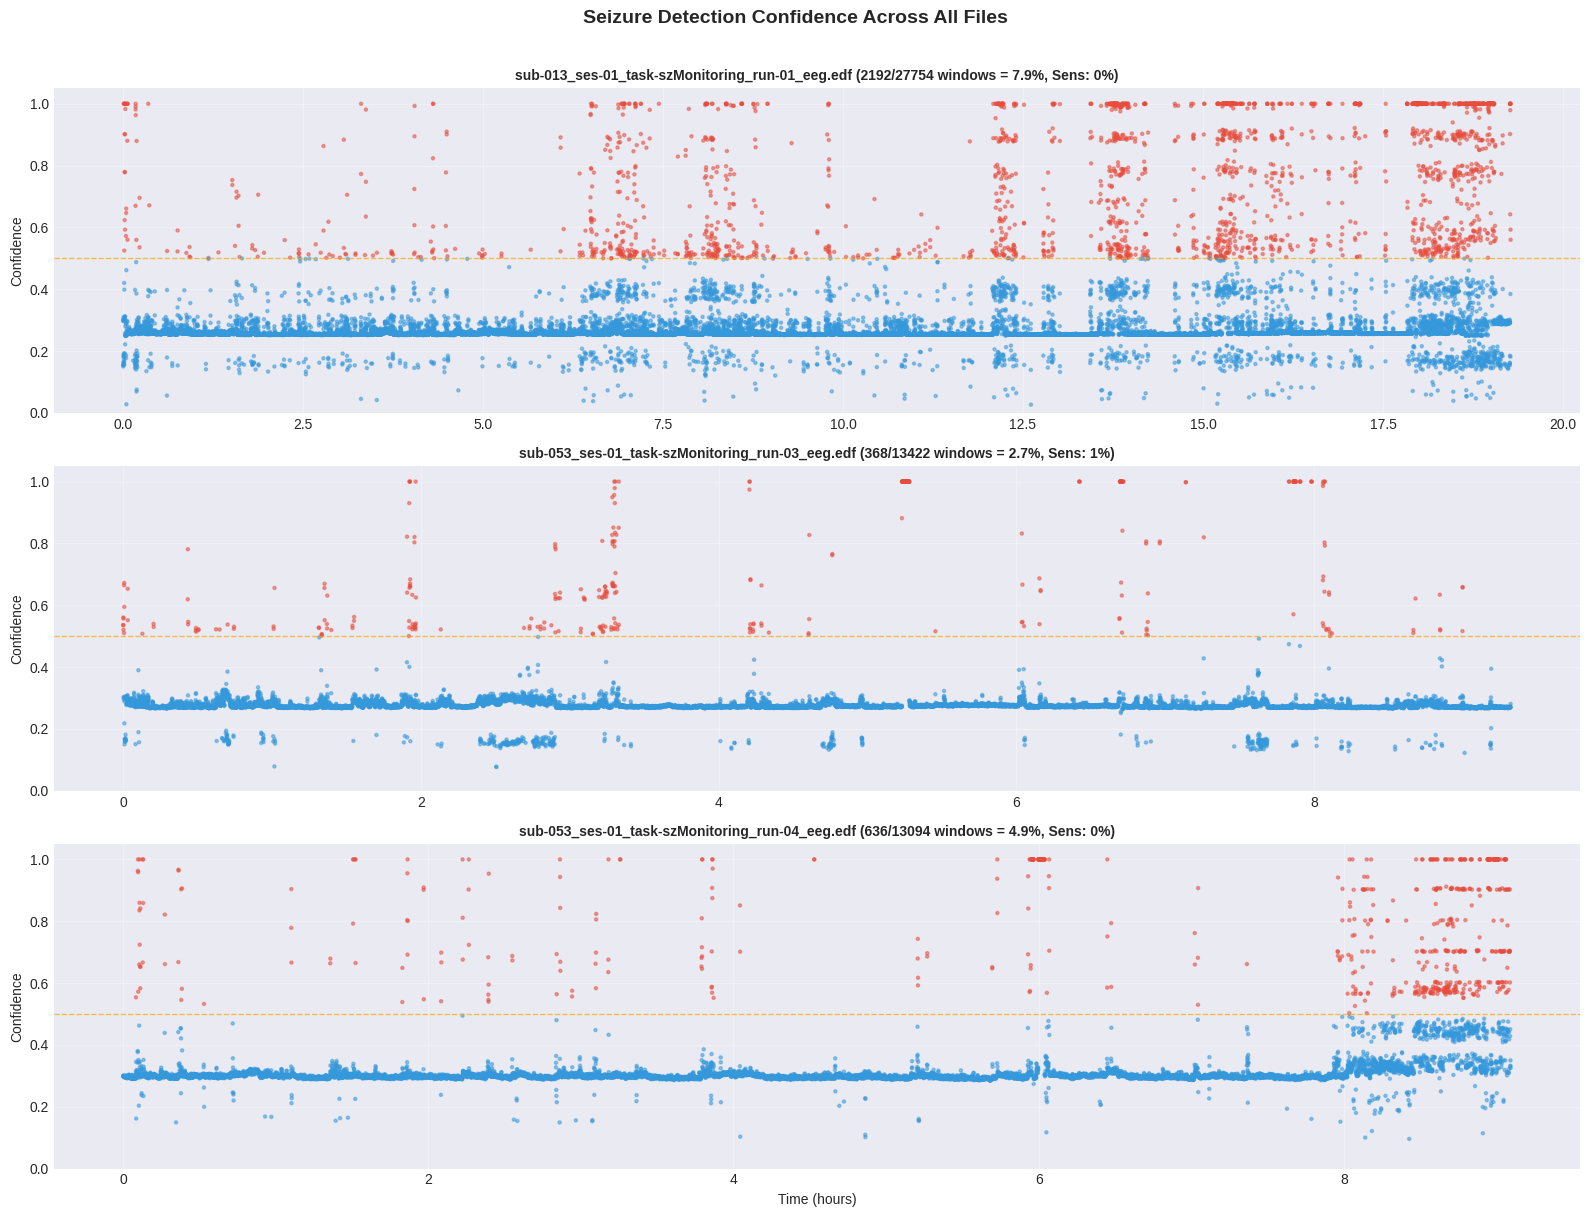


Generating per-file seizure visualizations...

Visualizing: sub-013_ses-01_task-szMonitoring_run-01_eeg.edf
Loaded EDF: 2 channels, 69388.00s duration
Loaded annotations: 2 seizure events found

Seizure Annotations from sub-013_ses-01_task-szMonitoring_run-01_events.txt:

Seizure 1:
  Time: 13124.0s - 13145.0s
  Duration: 21.0s
  Type: sz_foc_ia_nm
  Lateralization: left
  Localization: temp

Seizure 2:
  Time: 43588.0s - 43609.0s
  Duration: 21.0s
  Type: sz_foc_ia_nm
  Lateralization: left
  Localization: temp
Preprocessing...
  Bandpass filter: 0.5-40.0 Hz
  Notch filter: 60.0 Hz
  Using ICA artifact removal (placeholder)
✓ Preprocessing complete
Computing baseline from first 300.0 seconds...
  Baseline RMS: 0.000230
  Baseline STD: 0.000230
  Baseline computed successfully

Visualizing Seizure 1: sz_foc_ia_nm
  Time: 13124.0s - 13145.0s
  Duration: 21.0s


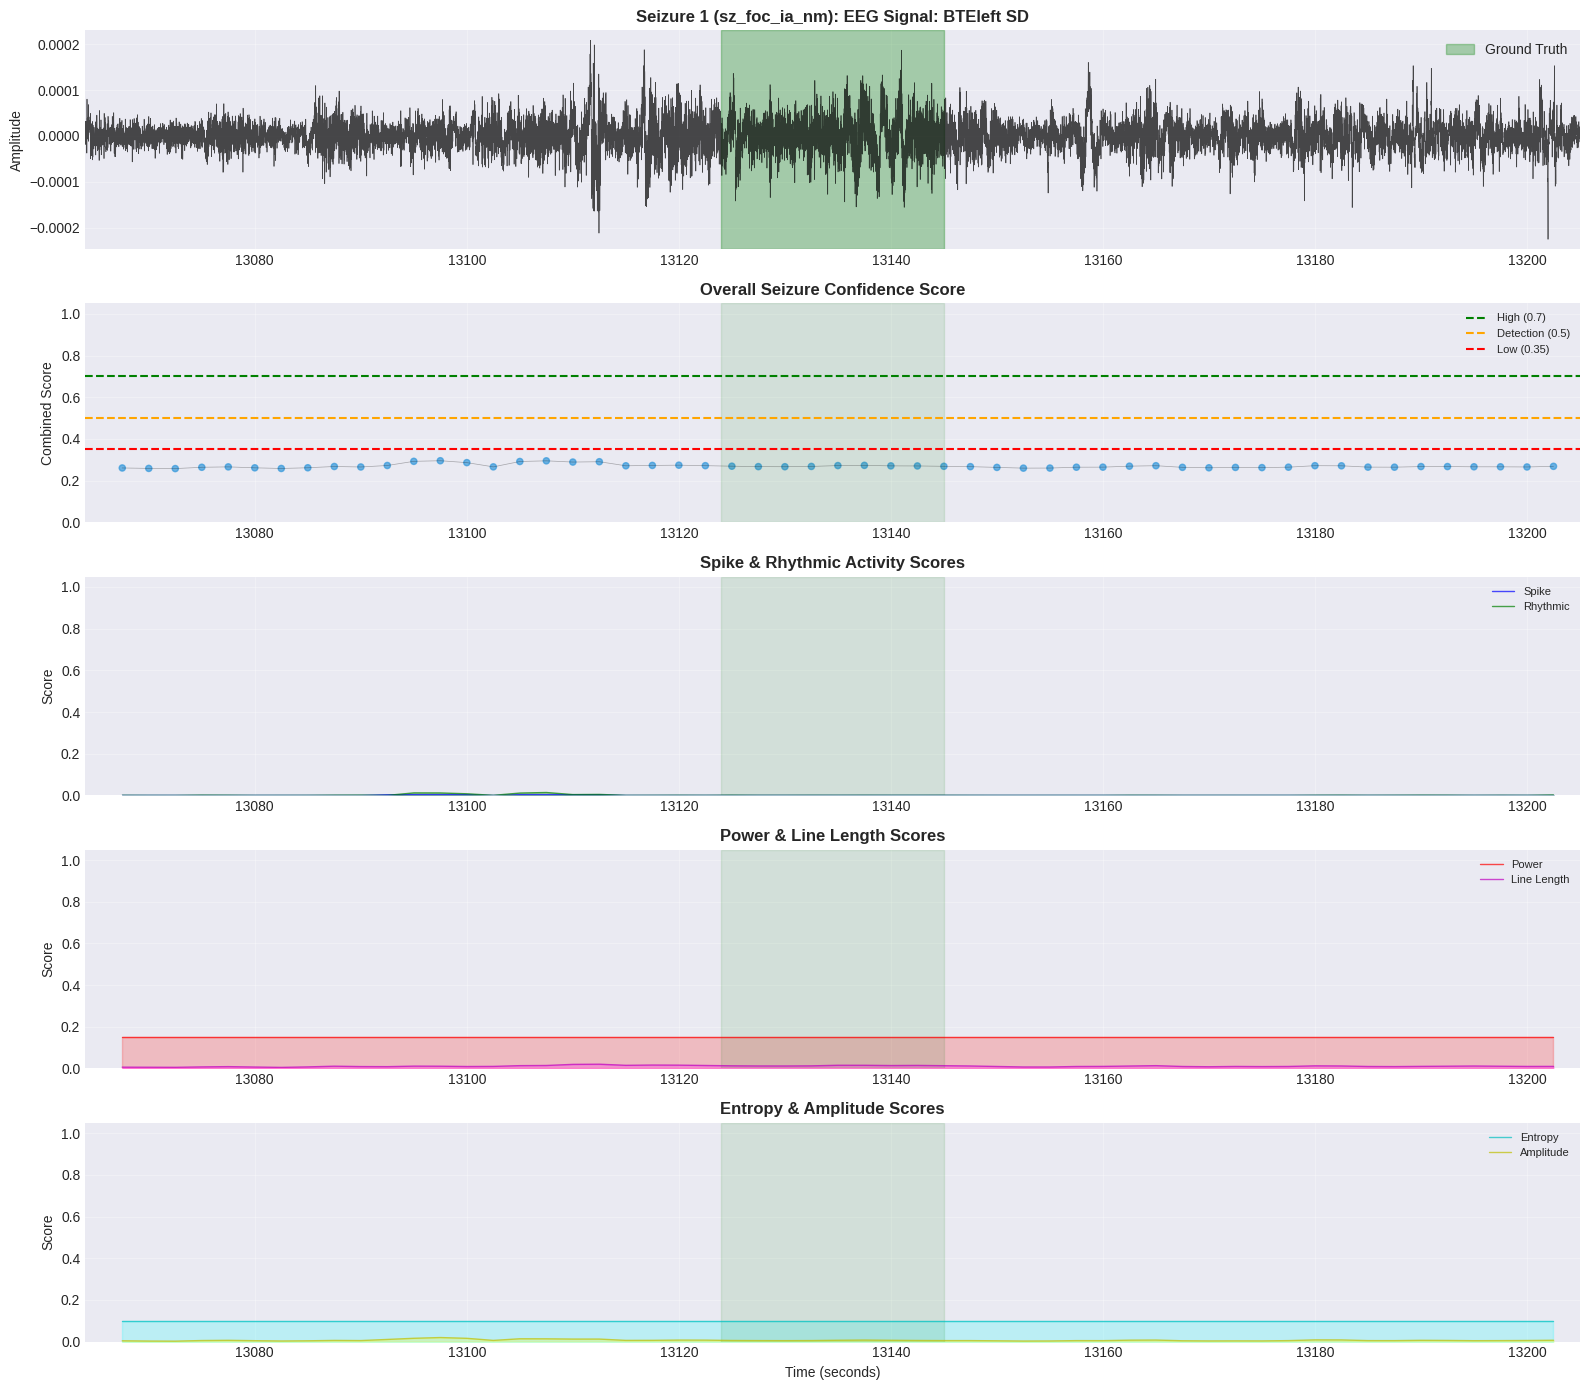


Visualizing Seizure 2: sz_foc_ia_nm
  Time: 43588.0s - 43609.0s
  Duration: 21.0s


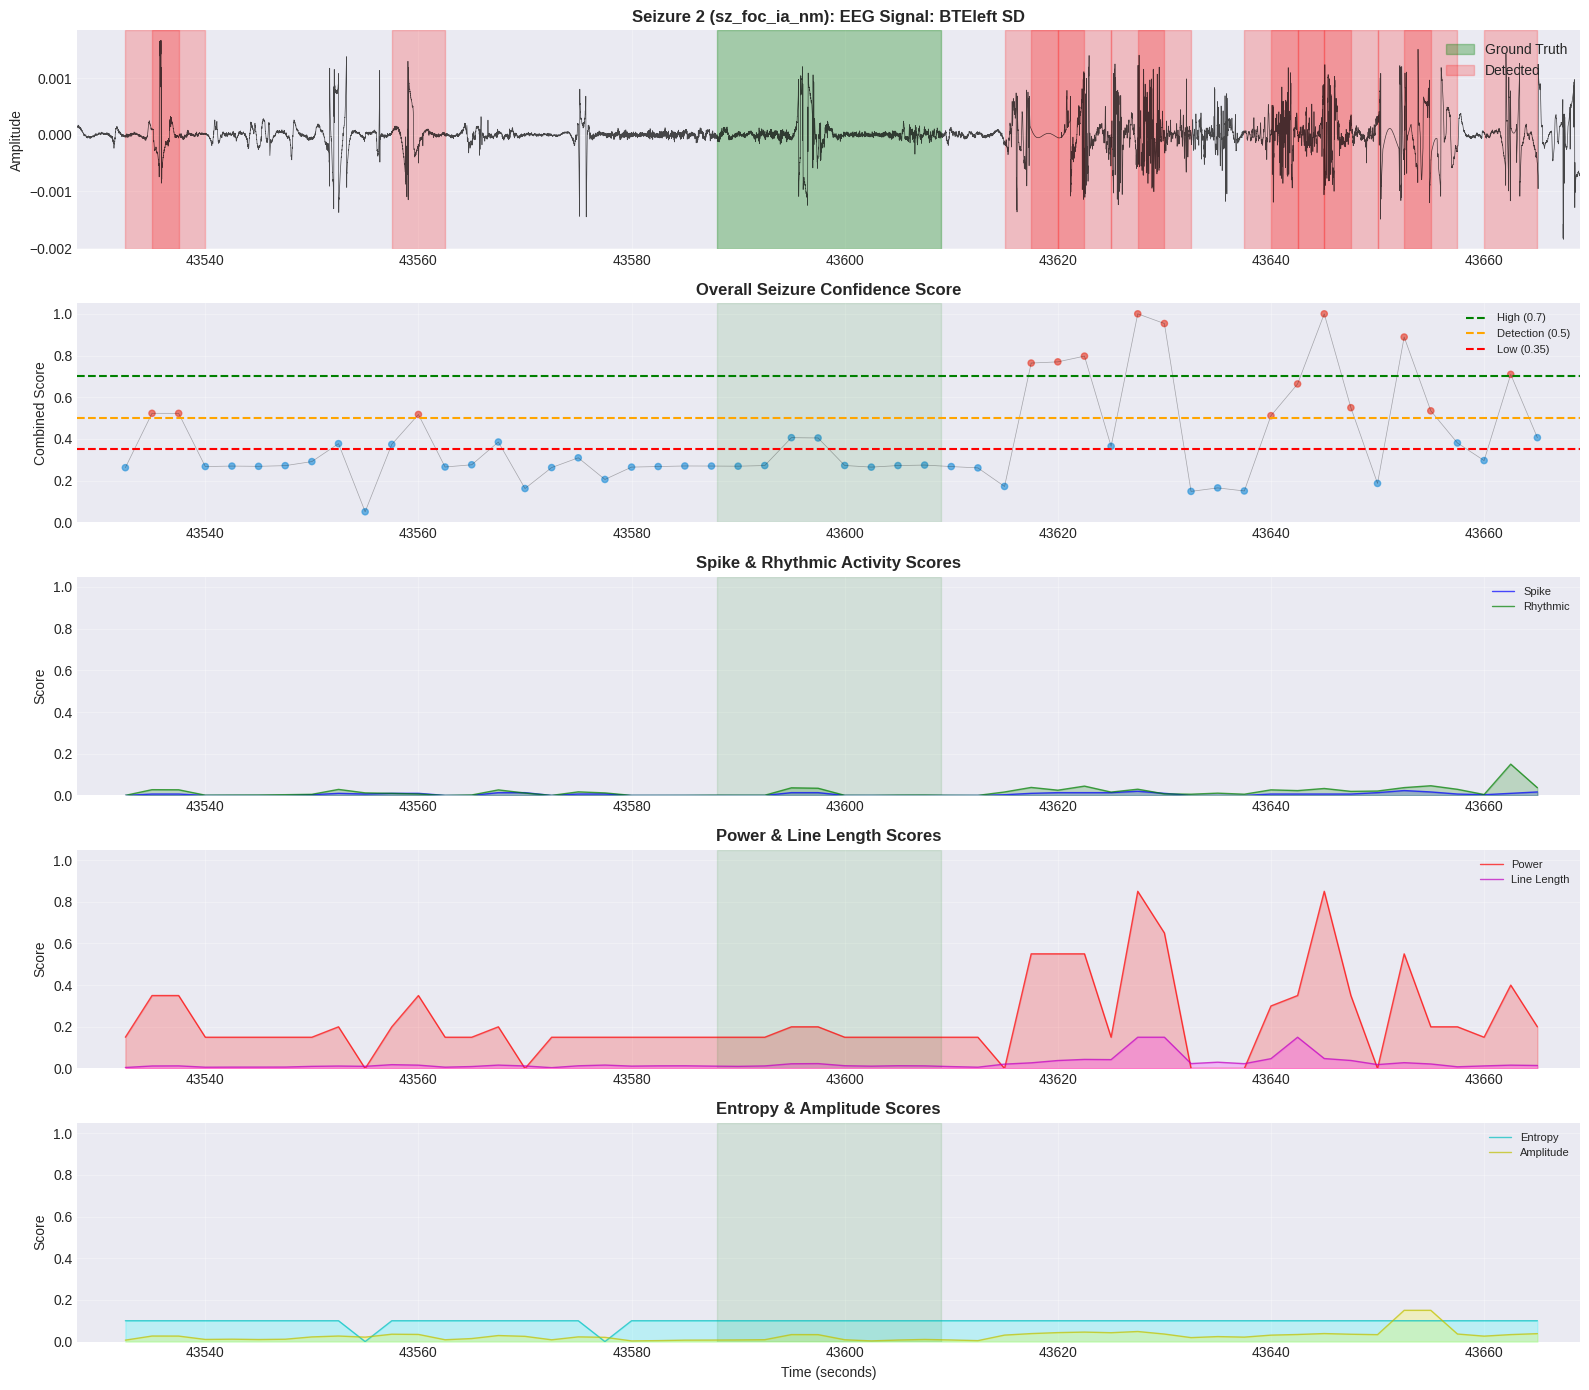


Visualizing: sub-053_ses-01_task-szMonitoring_run-03_eeg.edf
Loaded EDF: 2 channels, 33558.00s duration
Loaded annotations: 1 seizure events found

Seizure Annotations from sub-053_ses-01_task-szMonitoring_run-03_events.txt:

Seizure 1:
  Time: 31223.0s - 31476.0s
  Duration: 253.0s
  Type: sz_foc_a_m_hyperkinetic
  Lateralization: un
  Localization: un
Preprocessing...
  Bandpass filter: 0.5-40.0 Hz
  Notch filter: 60.0 Hz
  Using ICA artifact removal (placeholder)
✓ Preprocessing complete
Computing baseline from first 300.0 seconds...
  Baseline RMS: 0.000029
  Baseline STD: 0.000029
  Baseline computed successfully

Visualizing Seizure 1: sz_foc_a_m_hyperkinetic
  Time: 31223.0s - 31476.0s
  Duration: 253.0s


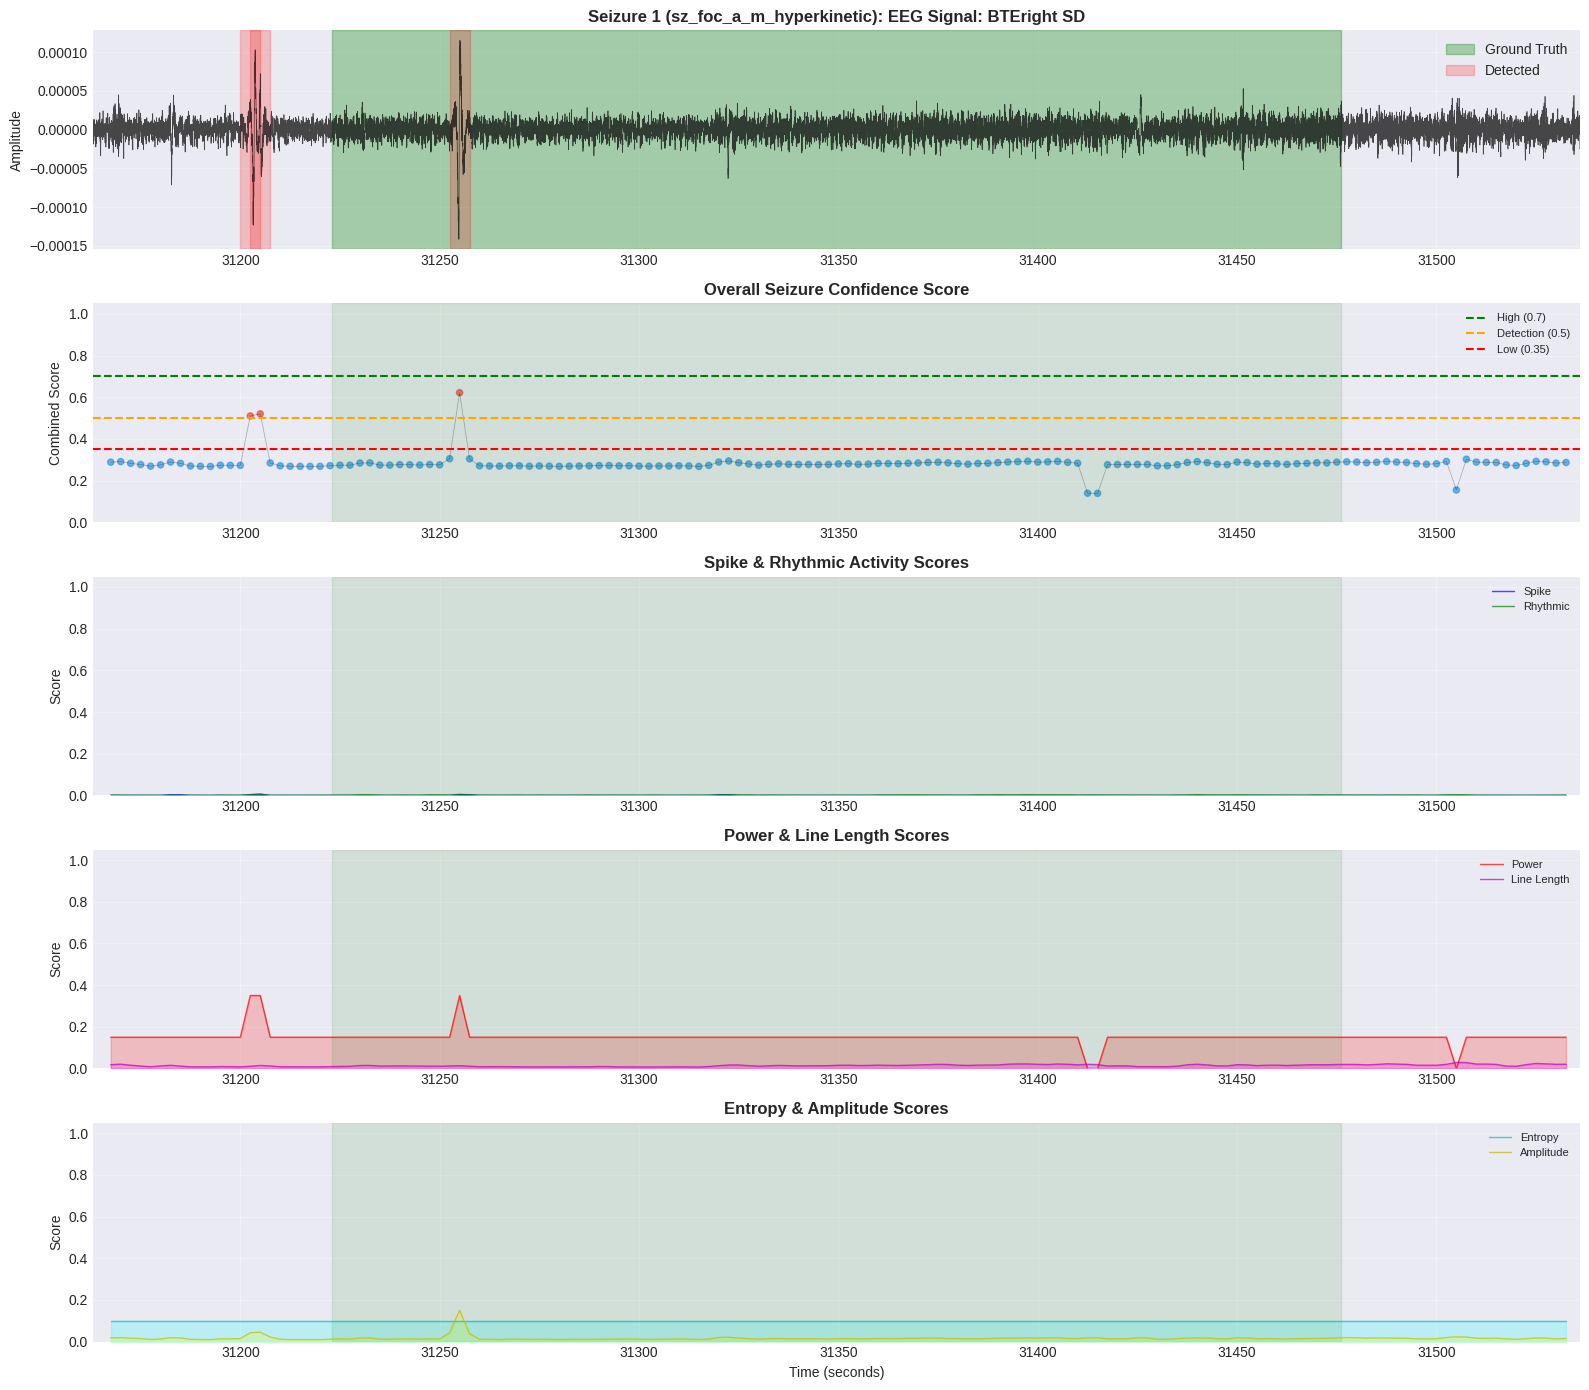


Visualizing: sub-053_ses-01_task-szMonitoring_run-04_eeg.edf
Loaded EDF: 2 channels, 32739.00s duration
Loaded annotations: 1 seizure events found

Seizure Annotations from sub-053_ses-01_task-szMonitoring_run-04_events.txt:

Seizure 1:
  Time: 13670.0s - 13676.0s
  Duration: 6.0s
  Type: sz_foc_a_m_hyperkinetic
  Lateralization: right
  Localization: temp
Preprocessing...
  Bandpass filter: 0.5-40.0 Hz
  Notch filter: 60.0 Hz
  Using ICA artifact removal (placeholder)
✓ Preprocessing complete
Computing baseline from first 300.0 seconds...
  Baseline RMS: 0.000009
  Baseline STD: 0.000009
  Baseline computed successfully

Visualizing Seizure 1: sz_foc_a_m_hyperkinetic
  Time: 13670.0s - 13676.0s
  Duration: 6.0s


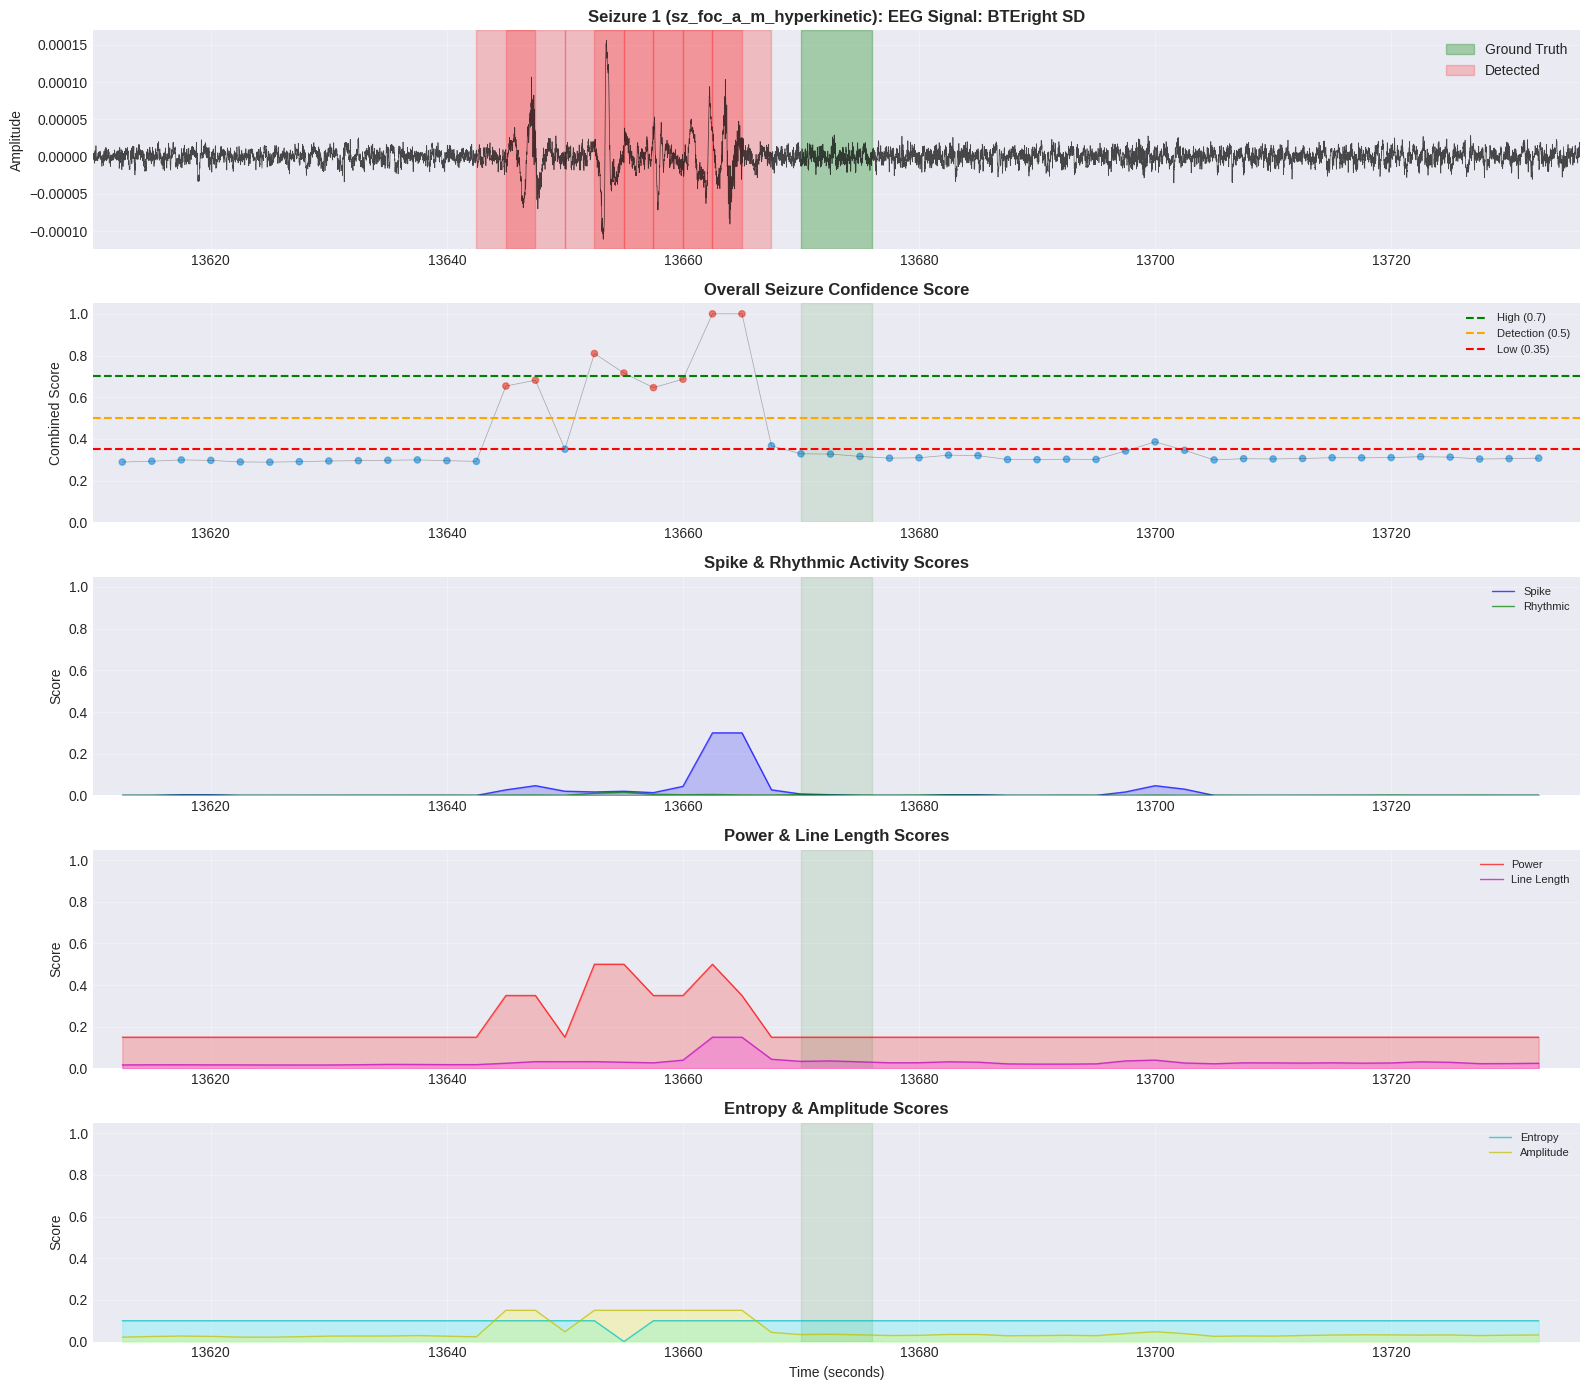


Batch visualization complete!


In [39]:
# Visualize batch results overview
print("\n" + "="*70)
print("BATCH VISUALIZATION")
print("="*70)

# Plot detection overview for all files
if batch_validation and 'all_results' in batch_validation:
    plot_batch_detection_overview(batch_validation)

# Visualize each file around its seizures
print("\nGenerating per-file seizure visualizations...")

edf_files = EEGDataLoader.list_available_edf_files('data')
for edf_path in edf_files:
    print(f"\n{'='*70}")
    print(f"Visualizing: {Path(edf_path).name}")
    print("="*70)

    # Load and process
    viz_loader = EEGDataLoader()
    viz_loader.load_from_edf(edf_path)

    viz_preprocessor = Preprocessor(CONFIG['preprocessing'])
    viz_data_clean = viz_preprocessor.preprocess(viz_loader.data, viz_loader.sfreq)

    viz_detector = SeizureDetector(sfreq=viz_loader.sfreq)
    viz_detector.compute_baseline(viz_data_clean, use_first_minutes=5.0)

    viz_analyzer = SlidingWindowAnalyzer(
        detector=viz_detector,
        window_size=5.0,
        overlap=0.5,
        sfreq=viz_loader.sfreq
    )

    viz_results = viz_analyzer.analyze_recording(viz_data_clean, show_progress=False)

    # Visualize around each seizure
    if viz_loader.annotations and len(viz_loader.annotations.events) > 0:
        for i in range(len(viz_loader.annotations.events)):
            visualize_seizure_around_ground_truth(
                loader=viz_loader,
                data_clean=viz_data_clean,
                results_df=viz_results,
                seizure_idx=i,
                context_seconds=60
            )
    else:
        # Show first 5 minutes
        plot_detection_analysis(
            results_df=viz_results,
            data=viz_data_clean,
            times=viz_loader.times,
            channel_names=viz_loader.channel_names,
            title_prefix=f"{Path(edf_path).name}: "
        )

print("\nBatch visualization complete!")

## 11. Batch Processing - Analyze All EDF Files

Process all available EDF files and generate a summary report

In [ ]:
def quick_test_pipeline(edf_path: str,
                       window_size: float = 5.0,
                       detection_threshold: float = 0.50,
                       baseline_minutes: float = 5.0):
    """
    Quick test of the full pipeline with custom parameters.
    Uses the new real signal analysis seizure detector.

    Parameters:
    -----------
    edf_path : str
        Path to EDF file
    window_size : float
        Window size in seconds
    detection_threshold : float
        Detection threshold (0-1)
    baseline_minutes : float
        Minutes of data to use for baseline computation
    """

    print("\n" + "="*70)
    print("QUICK PIPELINE TEST (Real Signal Analysis)")
    print("="*70)

    print(f"\nConfiguration:")
    print(f"  EDF file: {edf_path}")
    print(f"  Window size: {window_size}s")
    print(f"  Detection threshold: {detection_threshold}")
    print(f"  Baseline duration: {baseline_minutes} minutes")

    # Load data
    print("\n[1/5] Loading data...")
    test_loader = EEGDataLoader()
    test_loader.load_from_edf(edf_path)

    # Preprocess
    print("\n[2/5] Preprocessing...")
    test_preprocessor = Preprocessor(CONFIG['preprocessing'])
    test_data_clean = test_preprocessor.preprocess(test_loader.data, test_loader.sfreq)

    # Setup detector
    print("\n[3/5] Setting up seizure detector...")
    test_detector = SeizureDetector(sfreq=test_loader.sfreq)
    test_detector.params['detection_threshold'] = detection_threshold
    test_detector.compute_baseline(test_data_clean, use_first_minutes=baseline_minutes)

    # Analyze
    print("\n[4/5] Running analysis...")
    test_analyzer = SlidingWindowAnalyzer(
        detector=test_detector,
        window_size=window_size,
        overlap=0.5,
        sfreq=test_loader.sfreq
    )
    test_results = test_analyzer.analyze_recording(test_data_clean, show_progress=True, progress_interval=100)
    test_report = test_analyzer.generate_report(test_results)

    # Display results
    print("\n[5/5] Results:")
    print("="*70)
    print(f"Seizure events detected: {test_report['num_events']}")
    print(f"Detection rate: {test_report['detection_rate']:.2%}")

    if test_report['num_events'] > 0:
        for i, event in enumerate(test_report['seizure_events'][:5], 1):  # Show first 5
            print(f"\n  Event {i}: {event['seizure_type']}")
            print(f"    Time: {event['start_time']:.1f}-{event['end_time']:.1f}s")
            print(f"    Duration: {event['duration']:.1f}s")
            print(f"    Confidence: {event['max_confidence']:.2%}")

        if test_report['num_events'] > 5:
            print(f"\n  ... and {test_report['num_events'] - 5} more events")

    # Validation if annotations available
    if test_loader.annotations and len(test_loader.annotations.events) > 0:
        print("\n" + "-"*70)
        print("Validation against ground truth:")
        validation = validate_detections(test_results, test_loader.annotations)
        if validation:
            print(f"  Sensitivity: {validation['sensitivity']:.2%}")
            print(f"  Precision: {validation['precision']:.2%}")
            print(f"  F1-Score: {validation['f1_score']:.2%}")
            print(f"  Events detected: {validation['detected_events']}/{validation['total_ground_truth']}")

    print("\n" + "="*70)
    return test_results, test_report

# Run pipeline with real EDF data
print("\nRunning seizure detection pipeline on real EDF data:")
test_results, test_report = quick_test_pipeline(
    edf_path='data/sub-013_ses-01_task-szMonitoring_run-01_eeg.edf',
    window_size=5.0,
    detection_threshold=0.50
)


Running seizure detection pipeline on real EDF data:

QUICK PIPELINE TEST (Real Signal Analysis)

Configuration:
  EDF file: data/sub-013_ses-01_task-szMonitoring_run-01_eeg.edf
  Window size: 5.0s
  Detection threshold: 0.5
  Baseline duration: 5.0 minutes

[1/5] Loading data...
Loaded EDF: 2 channels, 69388.00s duration
Loaded annotations: 2 seizure events found

Seizure Annotations from sub-013_ses-01_task-szMonitoring_run-01_events.txt:

Seizure 1:
  Time: 13124.0s - 13145.0s
  Duration: 21.0s
  Type: sz_foc_ia_nm
  Lateralization: left
  Localization: temp

Seizure 2:
  Time: 43588.0s - 43609.0s
  Duration: 21.0s
  Type: sz_foc_ia_nm
  Lateralization: left
  Localization: temp

[2/5] Preprocessing...
Preprocessing...
  Bandpass filter: 0.5-40.0 Hz


## Next Steps

### When Your Data Becomes Available:

1. **Load Your Data**: Update the data loading section (Section 1) to load from your database
2. **Train Prototypes**: Use your labeled seizure data to create better prototypes (Section 5)
3. **Optimize Thresholds**: Adjust confidence thresholds based on validation data
4. **Test Algorithms**: Use the `quick_test_pipeline()` function to compare different algorithms

### Algorithm Customization:

- Modify `CONFIG` dictionary to switch algorithms
- Add new preprocessing methods to `Preprocessor` class
- Add new feature extraction methods to `FeatureExtractor` class
- Add new pattern matching algorithms to `PatternMatcher` class

### Example Usage:

```python
# Load your actual data
loader = EEGDataLoader()
loader.load_from_edf('/path/to/your/seizure_recording.edf')

# Run full pipeline
results, report = quick_test_pipeline(
    data_source='edf',
    edf_path='/path/to/your/seizure_recording.edf',
    window_size=5.0,
    high_threshold=0.80
)

# Export results
export_results(results, report, output_prefix='patient_001_session_01')
```